<a href="https://colab.research.google.com/github/kevinmcmanus/lto_utils/blob/master/lto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTO Utilities Library

The LTO Utilities library provides a set of useful functions for dealing with files output from the Little Thompson Observatory's radio telescope. These files, suffixed with '.lto' capture spectral information and the data processing pipeline produces them at approximately one-minute intervals throughout an observation.

For the purposes of this demo, a 24-hour drift scan observation is available in Google Cloud Storage.  Having the data in GCS complicates this demo somewhat in that the Google Colab virtual machine that is running this notebook needs to mount the GCS as a preliminary step.
The actual demonstration of obtaining and using the `lto_utils` library begins in the section entitled 'Clone the lto_utils' repo.

## Preliminaries

### References on Using Cloud Storage in Colab

These articles explain how to make Google Cloud Storage availabale within a Google Colab notebook, such as this one.

(https://medium.com/analytics-vidhya/how-to-access-files-from-google-cloud-storage-in-colab-notebooks-8edaf9e6c020)

(https://stackoverflow.com/questions/51715268/how-to-import-data-from-google-cloud-storage-to-google-colab)

(https://ostrokach.gitlab.io/post/google-colab-storage/)

### Authenticate and Mount GCS Bucket

In [1]:
#from google.colab import auth

#auth.authenticate_user()

In [2]:
#!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
#!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
#!apt -qq update
#!apt -qq install gcsfuse

In [3]:
#Mount the drive
#!mkdir lto_data
#!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 lto_data lto_data

In [4]:
#to mount your own google drive, do this:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the lto_utils Repo

In [5]:
#!git clone https://github.com/kevinmcmanus/lto_utils

In [1]:
import sys
sys.path.append('lto_utils')

In [2]:
from lto_utils.lto_file import LTO_File, getDriftScan, getSpectralCharacteristics, getLTOobs

In [3]:
import lto_utils.lto_file as lto

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord

## Read Single LTO File and Examine its Contents

In [6]:
obs_dir = r'C:\Users\Ellie\Documents\LTO Data' # dir where the observations live
obs_date = '2020_08_10' # dir of the day's observations
obs_file = 'LTO-SRGA-2020-08-10-03-07-17.lto' #a particular minute's observation

In [7]:
#create an LTO_File object and read its contents
lto_file = LTO_File(os.path.join(obs_dir, obs_date, obs_file))
print(lto_file)

LTO File; Obs Time: 2020-08-10 03:07:17 UT, Az: 180.00, El: 23.90, RA: 17.39, Dec: -25.80, from file: C:\Users\Ellie\Documents\LTO Data\2020_08_10\LTO-SRGA-2020-08-10-03-07-17.lto


In [8]:
#set the path to the object
#path = 'lto_data/2018_09_02/LTO-HI-2018-09-02-17-41-53.lto'

#simple peaks
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_10\LTO-SRGA-2020-08-10-03-23-30.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_08\LTO-SRGA-2020-08-08-04-00-09.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_11\LTO-SRGA-2020-08-11-04-09-41.lto'
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_10\LTO-SRGA-2020-08-10-03-42-05.lto'

#multi-peak
#path = r'C:\Users\Ellie\Documents\LTO Data\2020_08_11\LTO-SRGA-2020-08-11-03-57-38.lto'

#create an LTO_File object
#lto_file = lto.LTO_File(path)


`lto_file` object contains two attributes: `SpectralHeader` and `SpectralData`. Both are large data structures. The `SpectralHeader` has several subsections which are:

In [9]:
lto_file.SpectralHeader.keys()

dict_keys(['Magic', 'Observatory', 'ObsLocation', 'BeamPosition', 'ObsTime', 'Spectrum', 'RadioCalibrations', 'ProgramControl', 'SpectralCharacteristics'])

 
The subsection `SpectralCharacteristics`  contains summary information of the file. 
 This subsection is particularly useful.

In [10]:
lto_file.SpectralHeader['SpectralCharacteristics']

{'avespecpwr': 1.4806562031216337e-21,
 'varspecpwr': 1.2845309562441545e-45,
 'totalpwr': 1.857779338056717e-17,
 'numspecpwr': 12547,
 'numave': 26216,
 'numbad': 4,
 'aveindvpwr': 0.001749086775816977,
 'varindvpwr': 2.513764196798718e-10,
 'peakpwr': 1.8277951097746046e-21,
 'peakpwrfreq': 1420335500.0,
 'totalHIpwr': 4.848518983774729e-19,
 'numHIpwr': 290,
 'avecrpwr': 1.4761313112661905e-21,
 'varcrpwr': 1.575097912794377e-46,
 'numcrpwr': 12257,
 'avetsky': 106.9157943725586,
 'vartsky': 0.8263067350781387,
 'peaktsky': 132.38670692049885,
 'peaktskyfreq': 1420335500.0,
 'avefluxden': 21774.355317505102,
 'varfluxden': 277796.4769932825,
 'peakfluxden': 26879.339095681386,
 'peakfluxfreq': 1420335500.0,
 'badspec': False,
 'processing': 'Raw FFT',
 'user': ''}

`SpectralData` is a  dictionary which essentially captures the spectrum and some other frequency-dependent measures.  Each dictionary element is a vector of length `nfft`.

In [11]:
lto_file.SpectralData.keys()

dict_keys(['dopfreq', 'rawavepwr', 'rawvarpwr', 'calavepwr', 'flatten', 'tsky', 'fluxden', 'badline', 'HIline'])

In [12]:
#type and length of the tsky member of the dictionary
n = len(lto_file.SpectralData['tsky'])
type(lto_file.SpectralData['tsky']), f'Length: {n}'

(numpy.ndarray, 'Length: 16385')

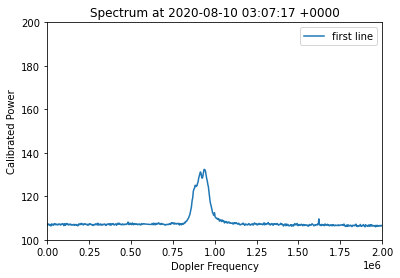

In [13]:
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['tsky'], label = 'first line')
#plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['tsky']*1.1, label = 'second line')
plt.xlim(0, 2000000)
plt.ylim(100, 200)
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')
plt.legend()
zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

Sometimes it's easier to work with a `Pandas` dataframe. The `LTO_File` class provides a method to do so.

In [14]:
import pandas as pd
pd_df = lto_file.to_pandas()
print(len(pd_df))
pd_df.tail()

16385


,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
16380,2020-08-10 03:07:17+00:00,17.391382,-25.800467,4997558.5,0.514033,2.664151e-01,4.034849e-19,182.158386,29224.300781,5.933601e+06,True,False
16381,2020-08-10 03:07:17+00:00,17.391382,-25.800467,4998169.0,0.822305,7.135391e-01,3.597608e-19,268.312256,26057.376953,5.290600e+06,True,False
16382,2020-08-10 03:07:17+00:00,17.391382,-25.800467,4998779.5,1.443286,2.096079e+00,2.366898e-19,491.400604,17143.380859,3.480732e+06,True,False
16383,2020-08-10 03:07:17+00:00,17.391382,-25.800467,4999389.5,0.001749,2.513764e-10,1.487929e-21,0.000000,107.770287,2.188131e+04,True,False
16384,2020-08-10 03:07:17+00:00,17.391382,-25.800467,5000000.0,0.001749,2.513764e-10,1.487929e-21,0.000000,107.770287,2.188131e+04,True,False


In [15]:
#testing locating variables of interest
#only want rows where HI line = true b/c no need to look for peaks elsewhere

#print(pd_df.loc[pd_df['HIline'] == True])

In [16]:
#smoothing slope to help get locate only true peaks

def smoothPascal(dataframe, centerIndex, column):
    pascalArray = np.array([1,6,15,20,15,6,1])
    #print(pascalArray)
    sum = 0
    for i in range(-3, 3):
        sum += (dataframe.at[(centerIndex + i), column]) * (pascalArray[3 + i])
        #print(sum)
        
    final = sum/64.0
   # if final < 0.2 and final > -0.2:
       # final = 0.0
        
    return final
        
    

In [17]:
def findPeaksValleys(df):
    
    peakList, valleyList = [], []
    
    for index in range(2, len(df)-3):

        if (df.loc[index, 'HIline']) and (df.loc[index, 'badline'] == False):
            
            #calculate slope for each point
            slope = (df['tsky'][index + 1] - df['tsky'][index] ) / (df['dopfreq'][index + 1] - df['dopfreq'][index])
            df.at[index, 'slope'] = slope * 10000
        
            #apply smoothing algorithm to slopes
            smoothSlope = smoothPascal(df, index, 'slope')
            df.at[index, 'smooth_slope'] = smoothSlope
            #print(pd_df.loc[index, ['tsky', 'HIline', 'slope', 'smooth_slope']])

            #use slope to identify peaks/valleys 
            #lastSlopeDiff = (pd_df.at[index-2, 'smooth_slope'] - pd_df.at[index -1, 'smooth_slope'])
            #nextSlopeDiff = (pd_df.at[index+2, 'smooth_slope'] - pd_df.at[index +1, 'smooth_slope'])
            #nextSlope= pd_df.at[index+1, 'smooth_slope']

            #between neg slope increasing and pos slope decreasing and close to zero (one ish)
            #slopes before are decreasing in magnitude and after are increasing
            #magDecrease = abs(pd_df.at[index -2, 'smooth_slope']) > abs(pd_df.at[index -1, 'smooth_slope']) and abs(pd_df.at[index -1, 'smooth_slope']) > abs(pd_df.at[index, 'smooth_slope'])
            #magIncrease = abs(pd_df.at[index +2,'smooth_slope']) > abs(pd_df.at[index +1, 'smooth_slope']) and abs(pd_df.at[index +1, 'smooth_slope']) > abs(pd_df.at[index, 'smooth_slope'])

            #smoothing raw tsky
            smoothTsky = smoothPascal(df, index, 'tsky')
            df.at[index, 'smoothTsky'] = smoothTsky
            
            #boolean for index is highest/lowest in neighborhood
            maxRange = 25
            beginIndex = index - maxRange
            endIndex = index + maxRange
            dfRange = df.loc[beginIndex : endIndex, 'tsky']
            #print("type of dfRange is" + str(type(dfRange)))
            npRange = dfRange.to_numpy()
            #print("tsky at index is " + str(df.at[index, 'smoothTsky']))
            #print(npRange)
            isMax = (np.max(npRange) == df.at[index, 'tsky'])
            isMin = (np.min(npRange) == df.at[index, 'tsky'])
            
            #isMax = max(df.loc[index - maxRange: index + maxRange, 'smoothTsky']) == df.at[index, 'smoothTsky']
            #isMin = min(df.loc[index - maxRange: index + maxRange, 'smoothTsky']) == df.at[index, 'smoothTsky']

            df.at[index, 'isPeak'] = False
            df.at[index, 'isValley'] = False

            slopeThreshold = 0.3
            
            #if abs(smoothSlope) < slopeThreshold and lastSlopeDiff > 0 and nextSlopeDiff < 0 and isMax:
            #if abs(smoothSlope) < 1 and magDecrease == True and magIncrease == True and isMax :
            if isMax:
                df.at[index, 'isPeak'] = True
                peakList.append(index)

            #elif abs(smoothSlope) < slopeThreshold and lastSlopeDiff < 0 and nextSlopeDiff > 0 and isMin:
            #elif abs(smoothSlope) < 1 and magDecrease == True and magIncrease == True and isMin:
            if isMin:
                df.at[index, 'isValley'] = True
                valleyList.append(index)

            #print all rows where peak or valley == true
    #print(df.loc[df['isPeak'] == True])
    #print(df.loc[df['isValley'] == True])
            
    print(peakList)
    print(valleyList)
    return [peakList, valleyList]

In [18]:
def getAbsorbDepth(df):
    
    #returns lists with indexes of peaks and valleys in dataframe
    peaks, valleys = findPeaksValleys(df)
    maxTemp = 0
    for peak in peaks:
        if maxTemp <= df.at[peak, 'tsky']:
            maxTemp = df.at[peak, 'tsky']
    depthsList = []  
    
    dictEntry = {'ra': df.at[0, 'ra'], 'dec': df.at[0, 'dec'], 'abDep': 0.0, 'dopfreq': 0.0, 'maxTsky': maxTemp}
       
    
    for peakListIndex, peak in enumerate(peaks):
        #checks to see if at end of peaks list yet
        if peakListIndex >= len(peaks) -1:
            break
        
        for valley in valleys:
            #check to see if valley is in between peaks
            if (peak < valley and peaks[peakListIndex + 1] > valley):
                
                #identified peaks with smoothing, but using raw data here --- any reason one way or another?---------------
                
                x1 = df.at[peak, 'dopfreq']
                y1 = df.at[peak, 'tsky']
                x = df.at[peaks[peakListIndex +1], 'dopfreq']
                y = df.at[peaks[peakListIndex+1], 'tsky']
              
                xValley = df.at[valley, 'dopfreq']
                yValley = df.at[valley, 'tsky']

                #connect the peaks to get estimate of power at valley location
                m = (y - y1)/(x - x1)
                estimatedPower = (m * (xValley - x1)) + y1
                absorptionDepth = estimatedPower - yValley
                #print(absorptionDepth)
                
                #if absoption Depth is negative, set to 0
                if absorptionDepth < 0: absorptionDepth = 0.0
                
                #if outside range of freqs with known real valleys(less than 920 or greater than 935), set to 0
                if (xValley < 900000) or (xValley > 1000000):
                    absorptionDepth = 0.0
                
                #taking only largest depth
                if absorptionDepth > dictEntry['abDep']:
                    dictEntry = {'ra': df.at[valley, 'ra'], 'dec': df.at[valley, 'dec'], 'abDep': absorptionDepth, 'dopfreq': df.at[valley, 'dopfreq'], 'maxTsky': maxTemp }
                
                
            else:
                #print('Valley not between two peaks')
                continue
                
    #add depthsEntry to list
    depthsList.append(dictEntry)
    print(dictEntry['abDep'])
       
    return depthsList


In [19]:
getAbsorbDepth(pd_df)

[9691, 9728]
[9709]
3.368919769222572


[{'ra': 17.391382217407227,
  'dec': -25.800466537475586,
  'abDep': 3.368919769222572,
  'dopfreq': 925903.3125,
  'maxTsky': 132.38670349121094}]

**TODO:** check out the ra and dec columns above

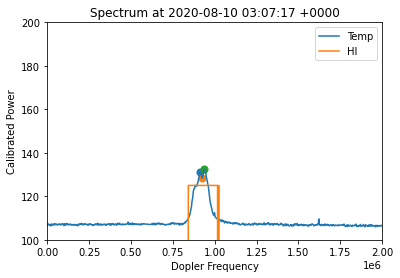

In [20]:
#reprint spectra with peaks/valleys shown
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['tsky'], label = 'Temp')
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['HIline']*125, label = 'HI')
for point in range(len(pd_df)-1):
    if (pd_df.at[point, 'HIline']) and ((pd_df.at[point, 'isPeak'] or pd_df.at[point, 'isValley'])):
        plt.scatter(pd_df.at[point, 'dopfreq'], pd_df.at[point, 'tsky'], 50)
plt.xlim(0, 2000000)
plt.ylim(100, 200)
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')
plt.legend()
zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

In [21]:
def writeLTOEfile(obs_date, ra, dec, absDepth, dopFreq, maxTsky = 0):
    name = obs_date + ".ltoe"
    fw= open(name, 'a')
    if fw.mode != 'a':
        print("Error: could not open file to append \n")
        exit()
    else:
        
        # outputs: ra, dec, galLong, galLat, absDepth, 1, dopFreq, maxTsky
        raDeg = ra * (360.0/24)
        decDeg = dec
        fw.write(      str(raDeg))
        fw.write(' ' + str(decDeg))
        c = SkyCoord(raDeg, decDeg, frame = 'icrs', unit = 'deg')
        fw.write(' ' + str(c.galactic.l.degree))
        fw.write(' ' + str(c.galactic.b.degree))
        fw.write(' ' + str(absDepth))
        fw.write(' ' + '1')
        fw.write(' ' + str(dopFreq))
        fw.write(' ' + str(maxTsky))
        fw.write('\r\n')
        fw.close()

In [22]:
def absDepthforEntireDay(obs_dir, obs_date):
    dayLongList = []
    for i, lto in enumerate(getLTOobs(os.path.join(obs_dir, obs_date))):
    #for i, lto in enumerate(getLTOobs(r'C:\Users\Ellie\Documents\LTO Data\2020_08_10')):

        #if i <= 170 or i >= 200:
            #continue

        pd_df = lto.to_pandas()
        print(pd_df.at[1, 'ts'])
        dayLongList += (getAbsorbDepth(pd_df))
        #print(getAbsorbDepth(pd_df))
        #print (dayLongList)
    print("Got dictionaries for all spectra")
    Xaxis = []
    Yaxis = []
    colormap = []

    for d in dayLongList:
        #experimenting with not creating lists to see if speeds up process
        #Xaxis.append(d['ra'])
        #print(Xaxis)
        #Yaxis.append(d['dec'])
        #colormap.append(d['abDep'])
        
        #put maxPeak in here
        writeLTOEfile(obs_date, d['ra'], d['dec'], d['abDep'], d['dopfreq'], d['maxTsky'])
    
    
    return Xaxis, Yaxis, colormap

In [23]:
#absDepthforEntireDay(r'C:\Users\Ellie\Documents\LTO Data', '2020_08_10')

In [24]:
#looping through all dates in LTO DATA (i.e. my entire dataset)
i = 1
while i <= 28:
    if i < 8:
        if i < 2:
            day = "2020_09_0" + str(i)
        else:
            i += 1
            continue
    elif i < 10:
        day = "2020_08_0" + str(i)
    else:
        day = "2020_08_" + str(i)
        
    absDepthforEntireDay(r'C:\Users\Ellie\Documents\LTO Data', day)
    #print(day)
    i += 1

2020-09-01 00:00:00+00:00
[9722]
[]
0.0
2020-09-01 00:00:56+00:00
[9726]
[]
0.0
2020-09-01 00:01:49+00:00
[9726]
[]
0.0
2020-09-01 00:02:39+00:00
[9725]
[]
0.0
2020-09-01 00:03:30+00:00
[9725]
[]
0.0
2020-09-01 00:04:21+00:00
[9727]
[]
0.0
2020-09-01 00:05:11+00:00
[9606, 9724]
[]
0.0
2020-09-01 00:06:03+00:00
[9727]
[]
0.0
2020-09-01 00:06:55+00:00
[9726]
[]
0.0
2020-09-01 00:07:46+00:00
[9728]
[]
0.0
2020-09-01 00:08:37+00:00
[9728]
[]
0.0
2020-09-01 00:09:28+00:00
[9729]
[]
0.0
2020-09-01 00:10:21+00:00
[9724]
[]
0.0
2020-09-01 00:11:17+00:00
[9729]
[]
0.0
2020-09-01 00:12:11+00:00
[9726]
[]
0.0
2020-09-01 00:13:03+00:00
[9728]
[]
0.0
2020-09-01 00:13:54+00:00
[1994, 9728]
[]
0.0
2020-09-01 00:14:45+00:00
[9726]
[]
0.0
2020-09-01 00:15:36+00:00
[9727]
[]
0.0
2020-09-01 00:16:27+00:00
[9725]
[]
0.0
2020-09-01 00:17:18+00:00
[9728]
[]
0.0
2020-09-01 00:18:09+00:00
[9727]
[]
0.0
2020-09-01 00:19:00+00:00
[9727]
[]
0.0
2020-09-01 00:19:52+00:00
[9727]
[]
0.0
2020-09-01 00:20:43+00:00
[9

[9498, 9617, 9750, 9891, 10061]
[9512, 9669]
8.60976562635338
2020-09-01 02:42:37+00:00
[9508, 9626, 9750, 9916, 10056]
[9544, 9698]
10.010836910381755
2020-09-01 02:43:30+00:00
[9254, 9490, 9617, 9752, 9889, 10039]
[9529, 9687]
9.848067971274531
2020-09-01 02:44:22+00:00
[9070, 9231, 9263, 9485, 9620, 9745, 9893, 10042]
[9549, 9683]
10.052677716290617
2020-09-01 02:45:13+00:00
[8953, 8981, 9025, 9096, 9220, 9255, 9475, 9623, 9747, 9905, 10072]
[9551, 9690]
10.46465237854423
2020-09-01 02:46:04+00:00
[8978, 9004, 9048, 9079, 9109, 9234, 9496, 9631, 9750, 9914, 10056]
[9220, 9251, 9549, 9694]
10.126732990664607
2020-09-01 02:46:57+00:00
[8906, 8960, 9027, 9085, 9134, 9481, 9626, 9748, 10050]
[8991, 9227, 9541, 9696]
10.635371861730704
2020-09-01 02:47:49+00:00
[8954, 9001, 9054, 9092, 9123, 9478, 9622, 9743, 9893, 10063]
[8921, 8979, 9009, 9039, 9107, 9226, 9546, 9698]
10.027801833287242
2020-09-01 02:48:47+00:00
[8974, 9012, 9049, 9228, 9464, 9623, 9748, 9919, 10054]
[8880, 8956, 9006,

[9771]
[]
0.0
2020-09-01 03:50:59+00:00
[9768]
[]
0.0
2020-09-01 03:51:52+00:00
[9769]
[]
0.0
2020-09-01 03:52:50+00:00
[9774]
[]
0.0
2020-09-01 03:53:45+00:00
[9773]
[]
0.0
2020-09-01 03:54:37+00:00
[9779]
[]
0.0
2020-09-01 03:55:30+00:00
[9782]
[]
0.0
2020-09-01 03:56:22+00:00
[9780]
[]
0.0
2020-09-01 03:57:16+00:00
[9785]
[]
0.0
2020-09-01 03:58:10+00:00
[9787]
[]
0.0
2020-09-01 03:59:03+00:00
[9787]
[]
0.0
2020-09-01 03:59:55+00:00
[9789]
[]
0.0
2020-09-01 04:00:49+00:00
[9791]
[]
0.0
2020-09-01 04:01:42+00:00
[9793]
[]
0.0
2020-09-01 04:02:36+00:00
[9791]
[]
0.0
2020-09-01 04:03:34+00:00
[9794]
[]
0.0
2020-09-01 04:04:30+00:00
[9792]
[]
0.0
2020-09-01 04:05:23+00:00
[9793]
[]
0.0
2020-09-01 04:06:15+00:00
[9796]
[]
0.0
2020-09-01 04:07:08+00:00
[9795]
[9703]
0.0
2020-09-01 04:08:01+00:00
[9795]
[9699]
0.0
2020-09-01 04:08:55+00:00
[9701, 9795]
[9719]
4.213369288649574
2020-09-01 04:09:48+00:00
[9704, 9797]
[]
0.0
2020-09-01 04:10:40+00:00
[9688, 9798]
[9722]
6.190260399904446
2020

2020-08-08 00:24:09+00:00
[9662, 9722]
[9705]
1.1223059262687656
2020-08-08 00:25:03+00:00
[9671, 9730]
[9698]
1.3227958539633562
2020-08-08 00:25:56+00:00
[5047, 8981, 9679, 9728]
[]
0.0
2020-08-08 00:26:50+00:00
[6754, 9676, 9828]
[9708]
0.5023939803545687
2020-08-08 00:27:42+00:00
[9677]
[]
0.0
2020-08-08 00:28:34+00:00
[6754, 8981, 9671, 9728]
[9705]
1.2741913135820795
2020-08-08 00:29:27+00:00
[9670, 9728]
[9708]
0.9611484957827798
2020-08-08 00:30:21+00:00
[9676]
[]
0.0
2020-08-08 00:31:15+00:00
[9671]
[]
0.0
2020-08-08 00:32:09+00:00
[9674]
[]
0.0
2020-08-08 00:33:02+00:00
[9675, 9726]
[]
0.0
2020-08-08 00:33:53+00:00
[5048, 9674, 9729]
[9707]
1.0467453002929688
2020-08-08 00:34:47+00:00
[9683]
[]
0.0
2020-08-08 00:35:40+00:00
[9682]
[]
0.0
2020-08-08 00:36:33+00:00
[5048, 9676]
[]
0.0
2020-08-08 00:37:26+00:00
[9685]
[]
0.0
2020-08-08 00:38:18+00:00
[9672, 9828]
[]
0.0
2020-08-08 00:39:09+00:00
[5047, 8981, 9688]
[]
0.0
2020-08-08 00:40:03+00:00
[8981, 9675, 9827]
[]
0.0
2020-0

2020-08-08 02:58:54+00:00
[9713]
[]
0.0
2020-08-08 02:59:49+00:00
[9715]
[]
0.0
2020-08-08 03:00:43+00:00
[9721]
[]
0.0
2020-08-08 03:01:36+00:00
[9719]
[]
0.0
2020-08-08 03:02:27+00:00
[9718]
[]
0.0
2020-08-08 03:03:20+00:00
[9717]
[]
0.0
2020-08-08 03:04:12+00:00
[9720]
[]
0.0
2020-08-08 03:05:04+00:00
[9719]
[]
0.0
2020-08-08 03:05:57+00:00
[9724]
[]
0.0
2020-08-08 03:06:48+00:00
[9723]
[]
0.0
2020-08-08 03:07:40+00:00
[9720]
[]
0.0
2020-08-08 03:08:32+00:00
[9725]
[]
0.0
2020-08-08 03:09:24+00:00
[9719]
[]
0.0
2020-08-08 03:10:18+00:00
[9726]
[]
0.0
2020-08-08 03:11:10+00:00
[9702]
[]
0.0
2020-08-08 03:12:03+00:00
[9725]
[]
0.0
2020-08-08 03:12:56+00:00
[9700]
[]
0.0
2020-08-08 03:13:49+00:00
[9706]
[]
0.0
2020-08-08 03:14:42+00:00
[9705]
[]
0.0
2020-08-08 03:15:34+00:00
[9704]
[]
0.0
2020-08-08 03:16:27+00:00
[9705]
[]
0.0
2020-08-08 03:17:20+00:00
[9701]
[]
0.0
2020-08-08 03:18:12+00:00
[9704]
[]
0.0
2020-08-08 03:19:05+00:00
[9704]
[]
0.0
2020-08-08 03:19:59+00:00
[9699]
[]
0.0


[9708, 9827]
[]
0.0
2020-08-09 00:24:17+00:00
[7715, 9710, 9782, 9829]
[]
0.0
2020-08-09 00:25:15+00:00
[5047, 9656, 9708]
[9674]
1.218997325237254
2020-08-09 00:26:13+00:00
[9707, 9827]
[]
0.0
2020-08-09 00:27:10+00:00
[9709, 9828]
[9634]
0.0
2020-08-09 00:28:07+00:00
[9703, 9827]
[]
0.0
2020-08-09 00:29:04+00:00
[5048, 7715, 9709, 9827]
[9653]
0.0
2020-08-09 00:30:01+00:00
[9615, 9648, 9701, 9827]
[9669]
1.2339152728252856
2020-08-09 00:31:00+00:00
[5047, 7715, 9617, 9710, 9790]
[]
0.0
2020-08-09 00:31:58+00:00
[7715, 9626, 9706, 9828]
[9643]
0.0
2020-08-09 00:32:56+00:00
[7715, 9619, 9704]
[9661]
0.0
2020-08-09 00:33:53+00:00
[5047, 9711, 9828]
[9633, 9670]
3.039619632176482
2020-08-09 00:34:51+00:00
[7715, 9629, 9714, 9828]
[9644]
0.0
2020-08-09 00:35:49+00:00
[9623, 9702]
[9659]
0.0
2020-08-09 00:36:47+00:00
[5048, 9609, 9731]
[9657]
0.0
2020-08-09 00:37:45+00:00
[5048, 7715, 9621, 9709]
[9672]
2.4944622255859343
2020-08-09 00:38:43+00:00
[9618, 9718, 9828]
[9673]
2.02397757384066

[5048, 9671]
[]
0.0
2020-08-09 02:29:38+00:00
[9665]
[]
0.0
2020-08-09 02:30:32+00:00
[5048, 9667]
[]
0.0
2020-08-09 02:31:27+00:00
[9669]
[]
0.0
2020-08-09 02:32:22+00:00
[9681]
[]
0.0
2020-08-09 02:33:15+00:00
[9667]
[]
0.0
2020-08-09 02:34:10+00:00
[9673, 9905]
[]
0.0
2020-08-09 02:35:05+00:00
[9674]
[]
0.0
2020-08-09 02:36:00+00:00
[9678]
[]
0.0
2020-08-09 02:36:56+00:00
[9674, 9909]
[]
0.0
2020-08-09 02:37:52+00:00
[5048, 9683, 9902]
[]
0.0
2020-08-09 02:38:46+00:00
[9684, 9929]
[]
0.0
2020-08-09 02:39:42+00:00
[9680, 9885, 9934]
[]
0.0
2020-08-09 02:40:37+00:00
[5047, 9685]
[9886]
0.0
2020-08-09 02:41:32+00:00
[9683, 9973]
[9855, 9900]
0.0
2020-08-09 02:42:26+00:00
[9682, 9942]
[]
0.0
2020-08-09 02:43:20+00:00
[5048, 9682]
[]
0.0
2020-08-09 02:44:13+00:00
[5047, 9685, 9828]
[]
0.0
2020-08-09 02:45:08+00:00
[9685, 9937]
[]
0.0
2020-08-09 02:46:02+00:00
[9685]
[]
0.0
2020-08-09 02:46:57+00:00
[9688]
[]
0.0
2020-08-09 02:47:53+00:00
[9685]
[]
0.0
2020-08-09 02:48:49+00:00
[9688, 996

[9745]
[]
0.0
2020-08-09 04:58:14+00:00
[9742]
[]
0.0
2020-08-09 04:59:10+00:00
[9736]
[]
0.0
2020-08-09 05:00:07+00:00
[6752, 9742]
[]
0.0
2020-08-09 05:01:04+00:00
[9740]
[]
0.0
2020-08-09 05:02:01+00:00
[9737]
[]
0.0
2020-08-09 05:02:56+00:00
[9738]
[]
0.0
2020-08-09 05:03:52+00:00
[9743]
[]
0.0
2020-08-09 05:04:48+00:00
[9741]
[]
0.0
2020-08-09 05:05:44+00:00
[9744]
[]
0.0
2020-08-09 05:06:42+00:00
[9744]
[]
0.0
2020-08-09 05:07:41+00:00
[9741]
[]
0.0
2020-08-09 05:08:37+00:00
[9742]
[]
0.0
2020-08-09 05:09:34+00:00
[9740, 9827]
[]
0.0
2020-08-09 05:10:30+00:00
[9743]
[]
0.0
2020-08-09 05:11:27+00:00
[9739]
[]
0.0
2020-08-09 05:12:24+00:00
[9748]
[]
0.0
2020-08-09 05:13:21+00:00
[9744]
[]
0.0
2020-08-09 05:14:17+00:00
[9746]
[]
0.0
2020-08-09 05:15:13+00:00
[9748, 9827]
[]
0.0
2020-08-09 05:16:09+00:00
[9746]
[]
0.0
2020-08-09 05:17:05+00:00
[9750, 9828]
[]
0.0
2020-08-09 05:18:02+00:00
[9752]
[]
0.0
2020-08-09 05:19:01+00:00
[9748]
[]
0.0
2020-08-09 05:19:56+00:00
[9752]
[]
0.0
20

2020-08-10 01:45:09+00:00
[9673]
[]
0.0
2020-08-10 01:46:04+00:00
[5049, 9673]
[]
0.0
2020-08-10 01:46:58+00:00
[5049, 9676, 9716, 9828]
[]
0.0
2020-08-10 01:47:55+00:00
[5049, 9677]
[]
0.0
2020-08-10 01:48:50+00:00
[5049, 9675, 9719, 9801]
[]
0.0
2020-08-10 01:49:47+00:00
[5050, 9676]
[]
0.0
2020-08-10 01:50:41+00:00
[5050, 9679]
[]
0.0
2020-08-10 01:51:36+00:00
[5050, 9686]
[]
0.0
2020-08-10 01:52:32+00:00
[5050, 9683, 9798]
[]
0.0
2020-08-10 01:53:27+00:00
[5050, 6752, 9689]
[9776]
0.0
2020-08-10 01:54:22+00:00
[5049, 9682, 9796]
[]
0.0
2020-08-10 01:55:21+00:00
[5050, 6752, 9683, 9796]
[9772]
2.7017955611248112
2020-08-10 01:56:16+00:00
[5050, 9682, 9794]
[]
0.0
2020-08-10 01:57:12+00:00
[5050, 9681, 9792]
[9775]
2.827372756158681
2020-08-10 01:58:08+00:00
[5049, 9686, 9793]
[9775]
3.7432904376017007
2020-08-10 01:59:03+00:00
[5049, 9685, 9791]
[9775]
3.375840611538507
2020-08-10 02:00:00+00:00
[5049, 9687, 9795]
[9771]
4.11213229591506
2020-08-10 02:00:56+00:00
[5049, 9688, 9788]


[9685, 9737]
[9712]
7.20160481153286
2020-08-10 03:56:11+00:00
[9464, 9687, 9736]
[9714]
7.255569684538244
2020-08-10 03:57:03+00:00
[9691, 9736, 9975]
[9712]
6.3518764992559795
2020-08-10 03:57:55+00:00
[9695, 9736]
[9716]
6.059968521387702
2020-08-10 03:58:48+00:00
[9699, 9735]
[9715]
5.555019427468608
2020-08-10 03:59:42+00:00
[9697, 9736]
[9715]
4.864600140321045
2020-08-10 04:00:36+00:00
[9701, 9737]
[9715]
4.029270882111632
2020-08-10 04:01:29+00:00
[9500, 9694, 9734]
[9714]
3.975942665976561
2020-08-10 04:02:22+00:00
[9732]
[9714]
0.0
2020-08-10 04:03:15+00:00
[9698, 9730]
[]
0.0
2020-08-10 04:04:08+00:00
[9459, 9735]
[]
0.0
2020-08-10 04:05:00+00:00
[9732]
[]
0.0
2020-08-10 04:05:53+00:00
[9503, 9733]
[9523]
0.0
2020-08-10 04:06:45+00:00
[9731]
[]
0.0
2020-08-10 04:07:37+00:00
[9507, 9729]
[]
0.0
2020-08-10 04:08:30+00:00
[9517, 9586, 9727]
[9538]
0.0
2020-08-10 04:09:23+00:00
[9490, 9731]
[]
0.0
2020-08-10 04:10:15+00:00
[9516, 9730]
[9552]
0.0
2020-08-10 04:11:09+00:00
[9728]

2020-08-11 00:35:50+00:00
[9730, 9828]
[]
0.0
2020-08-11 00:36:44+00:00
[9732, 9828]
[]
0.0
2020-08-11 00:37:37+00:00
[9730]
[]
0.0
2020-08-11 00:38:31+00:00
[9729, 9827, 10851]
[]
0.0
2020-08-11 00:39:25+00:00
[9726, 9829]
[]
0.0
2020-08-11 00:40:20+00:00
[9728]
[]
0.0
2020-08-11 00:41:15+00:00
[9732, 9828]
[]
0.0
2020-08-11 00:42:09+00:00
[9724, 9829]
[]
0.0
2020-08-11 00:43:03+00:00
[9721, 9828]
[]
0.0
2020-08-11 00:43:57+00:00
[9720, 9827]
[]
0.0
2020-08-11 00:44:51+00:00
[9690, 9737]
[9709]
1.0537022673821497
2020-08-11 00:45:45+00:00
[9701, 9739, 9829]
[]
0.0
2020-08-11 00:46:40+00:00
[9731, 9828]
[9711]
0.0
2020-08-11 00:47:34+00:00
[9732]
[]
0.0
2020-08-11 00:48:27+00:00
[9737]
[]
0.0
2020-08-11 00:49:22+00:00
[9700, 9735, 9828]
[9675]
0.0
2020-08-11 00:50:16+00:00
[9720]
[9687]
0.0
2020-08-11 00:51:12+00:00
[9701, 9729]
[]
0.0
2020-08-11 00:52:07+00:00
[9706, 9740]
[]
0.0
2020-08-11 00:53:02+00:00
[9657, 9735, 9827]
[]
0.0
2020-08-11 00:53:56+00:00
[9740]
[9683]
0.0
2020-08-11

[9726]
[]
0.0
2020-08-11 03:18:41+00:00
[9729]
[]
0.0
2020-08-11 03:19:37+00:00
[9733]
[]
0.0
2020-08-11 03:20:32+00:00
[9736]
[]
0.0
2020-08-11 03:21:27+00:00
[9729]
[]
0.0
2020-08-11 03:22:22+00:00
[9731]
[]
0.0
2020-08-11 03:23:17+00:00
[9729]
[]
0.0
2020-08-11 03:24:14+00:00
[9738]
[]
0.0
2020-08-11 03:25:10+00:00
[9731]
[]
0.0
2020-08-11 03:26:05+00:00
[9726]
[]
0.0
2020-08-11 03:27:00+00:00
[9727]
[]
0.0
2020-08-11 03:27:56+00:00
[9724]
[]
0.0
2020-08-11 03:28:52+00:00
[9720]
[]
0.0
2020-08-11 03:29:48+00:00
[9719]
[]
0.0
2020-08-11 03:30:44+00:00
[9714]
[]
0.0
2020-08-11 03:31:39+00:00
[9706, 9749]
[]
0.0
2020-08-11 03:32:34+00:00
[9704]
[]
0.0
2020-08-11 03:33:29+00:00
[9705, 9748]
[9729]
2.2436020120317437
2020-08-11 03:34:25+00:00
[9702, 9750]
[]
0.0
2020-08-11 03:35:21+00:00
[9705, 9749]
[9732, 9862]
3.154344305594975
2020-08-11 03:36:17+00:00
[9706, 9749, 9891]
[9730]
3.3669415557781406
2020-08-11 03:37:12+00:00
[9701, 9751]
[9725]
3.8683793223602265
2020-08-11 03:38:07+00:

[9755, 9827]
[9782]
4.539761382801643
2020-08-11 05:42:18+00:00
[9827]
[9753]
0.0
2020-08-11 05:43:14+00:00
[9826, 10849]
[9774]
0.0
2020-08-11 05:44:10+00:00
[9827, 10849]
[9764]
0.0
2020-08-11 05:45:04+00:00
[9728, 9828, 10849]
[9749]
3.043709485113638
2020-08-11 05:46:00+00:00
[9828]
[]
0.0
2020-08-11 05:46:56+00:00
[9735, 9827, 10849]
[9757]
3.012174521196755
2020-08-11 05:47:50+00:00
[9829]
[]
0.0
2020-08-11 05:48:45+00:00
[9736, 9828, 10848]
[]
0.0
2020-08-11 05:49:39+00:00
[9828]
[9753]
0.0
2020-08-11 05:50:32+00:00
[9829]
[9771]
0.0
2020-08-11 05:51:30+00:00
[9744, 9829, 10849]
[]
0.0
2020-08-11 05:52:29+00:00
[9734, 9829]
[]
0.0
2020-08-11 05:53:27+00:00
[9738, 9829]
[9754]
2.52363656398299
2020-08-11 05:54:24+00:00
[9767, 9829]
[9761]
0.0
2020-08-11 05:55:22+00:00
[9762, 9837, 10848]
[9769]
1.7766905381323141
2020-08-11 05:56:18+00:00
[9730, 9843]
[]
0.0
2020-08-11 05:57:13+00:00
[9762, 9845]
[]
0.0
2020-08-11 05:58:08+00:00
[9760, 9851, 10849]
[]
0.0
2020-08-11 05:59:04+00:0

[9624, 9743]
[9772]
0.0
2020-08-12 01:29:57+00:00
[9629, 9748, 9796]
[9769]
1.0819685718912808
2020-08-12 01:30:49+00:00
[9636, 9828, 9884]
[9729, 9811]
6.105325610579428
2020-08-12 01:31:44+00:00
[9632, 9734, 9775, 9828]
[9716, 9767]
2.623318137952751
2020-08-12 01:32:37+00:00
[9632, 9772, 9827]
[9706, 9766]
5.629749134423889
2020-08-12 01:33:32+00:00
[9631, 9781, 9828]
[9726]
5.09619183702597
2020-08-12 01:34:27+00:00
[9630, 9827, 9887]
[9716]
7.609131832078901
2020-08-12 01:35:20+00:00
[9643, 9731]
[9714]
3.715379583575995
2020-08-12 01:36:13+00:00
[9632, 9828, 9889]
[]
0.0
2020-08-12 01:37:07+00:00
[9635, 9763, 9827]
[9720]
5.723931250573727
2020-08-12 01:38:01+00:00
[9636, 9746, 9828]
[9721]
4.286088823348308
2020-08-12 01:38:56+00:00
[9638, 9797, 9828]
[9711, 9776]
8.69640768130813
2020-08-12 01:39:49+00:00
[9638, 9828]
[9712]
9.956473652093692
2020-08-12 01:40:42+00:00
[9639, 9739]
[9705]
6.74727078824111
2020-08-12 01:41:35+00:00
[9638, 9735, 9828]
[9708, 9792]
5.48455489381231

[9480, 9731, 10139, 10198, 10385, 10562, 10598]
[9521, 10128, 10165, 10284, 10315, 10577]
0.0
2020-08-12 02:59:33+00:00
[9466, 9742, 10155, 10183, 10236, 10306, 10409, 10504, 10538, 10568, 10613]
[9510, 10085, 10148, 10260, 10299, 10342]
0.0
2020-08-12 03:00:29+00:00
[9473, 9716, 9746, 9908, 10129, 10186, 10249, 10306, 10354, 10390, 10520, 10591]
[9511, 10144, 10223, 10336, 10374]
0.0
2020-08-12 03:01:25+00:00
[9466, 9735, 10212, 10306, 10350, 10403, 10601]
[9512, 10167]
0.0
2020-08-12 03:02:21+00:00
[9741, 10164, 10201, 10253, 10281, 10336, 10371, 10401, 10618]
[10155]
0.0
2020-08-12 03:03:18+00:00
[9472, 9715, 10127, 10204, 10250, 10288, 10371, 10410]
[9510, 10116, 10181]
0.0
2020-08-12 03:04:13+00:00
[9484, 9724, 9889, 10394, 10425, 10457]
[9501, 10141]
0.0
2020-08-12 03:05:08+00:00
[9483, 9733, 9887, 10182, 10340, 10400, 10436]
[9869]
0.0
2020-08-12 03:06:04+00:00
[9470, 9718, 10383]
[9491, 9868]
0.0
2020-08-12 03:06:59+00:00
[9476, 9739, 9885, 10381]
[9497, 9863]
0.0
2020-08-12 03

2020-08-12 05:39:51+00:00
[9761, 9827]
[]
0.0
2020-08-12 05:40:46+00:00
[9746, 9827]
[9717]
0.0
2020-08-12 05:41:41+00:00
[9733, 9764, 9828]
[]
0.0
2020-08-12 05:42:36+00:00
[9754]
[]
0.0
2020-08-12 05:43:31+00:00
[9757]
[]
0.0
2020-08-12 05:44:25+00:00
[9735]
[]
0.0
2020-08-12 05:45:20+00:00
[9693, 9766]
[]
0.0
2020-08-12 05:46:15+00:00
[9768, 9828]
[]
0.0
2020-08-12 05:47:10+00:00
[9735, 9779, 9828]
[9753]
0.4674473755214592
2020-08-12 05:48:06+00:00
[9729, 9772]
[9750]
0.7876621658238179
2020-08-12 05:49:01+00:00
[9760, 9828]
[9749]
0.0
2020-08-12 05:49:56+00:00
[9756]
[]
0.0
2020-08-12 05:50:51+00:00
[9755, 9827]
[]
0.0
2020-08-12 05:51:46+00:00
[9768, 9829]
[]
0.0
2020-08-12 05:52:41+00:00
[9734, 9828]
[]
0.0
2020-08-12 05:53:36+00:00
[9760]
[9731]
0.0
2020-08-12 05:54:31+00:00
[9771]
[9759]
0.0
2020-08-12 05:55:25+00:00
[9749]
[]
0.0
2020-08-12 05:56:19+00:00
[9766, 9876]
[]
0.0
2020-08-12 05:57:14+00:00
[9770]
[]
0.0
2020-08-12 05:58:10+00:00
[9747, 9828]
[9756]
1.01356038080503

[9635, 9730, 9828]
[9699]
3.78291321611637
2020-08-13 01:21:18+00:00
[9632, 9741, 9828]
[9715, 9809]
3.641390035389435
2020-08-13 01:22:11+00:00
[9628, 9736, 9828]
[9716, 9809]
2.655597781461637
2020-08-13 01:23:04+00:00
[9639, 9734, 9828]
[9714, 9775, 9808]
3.1985349010856936
2020-08-13 01:23:57+00:00
[9630, 9739, 9776, 9828]
[9709, 9794]
3.7904923766659095
2020-08-13 01:24:50+00:00
[9635, 9733, 9828]
[9717, 9809]
2.5714631673525616
2020-08-13 01:25:44+00:00
[9631, 9740, 9827]
[9705, 9799]
4.7959921553487135
2020-08-13 01:26:37+00:00
[9634, 9732, 9828]
[9708, 9783, 9812]
4.017761743957408
2020-08-13 01:27:31+00:00
[9636, 9735, 9828]
[9708, 9790]
4.638203800889116
2020-08-13 01:28:25+00:00
[9633, 9721, 9827]
[9702, 9806]
3.6243975421963768
2020-08-13 01:29:18+00:00
[9637, 9731, 9827, 9880]
[9708, 9787, 9858]
4.2981111034698785
2020-08-13 01:30:11+00:00
[9632, 9734, 9828]
[9710, 9791]
4.14374367482236
2020-08-13 01:31:06+00:00
[9633, 9732, 9828]
[9705, 9807]
5.1442449539943595
2020-08-1

[9397, 9452, 9695, 9782, 10191, 10374, 10599]
[9440, 9730, 10130, 10295]
1.981231771583083
2020-08-13 02:46:11+00:00
[9407, 9440, 9710, 9752, 10194, 10227, 10350, 10595]
[9434, 9489, 9730, 10103, 10149, 10294]
2.032408268563131
2020-08-13 02:47:08+00:00
[9383, 9444, 9692, 9748, 10117, 10181, 10328, 10368, 10475, 10580, 10608]
[9725, 10097, 10144, 10304]
1.8553425274198503
2020-08-13 02:48:02+00:00
[9425, 9478, 9605, 9697, 9752, 10166, 10205, 10361, 10606, 10635]
[9402, 9439, 9494, 10111, 10317]
0.0
2020-08-13 02:48:57+00:00
[9481, 9703, 9757, 10204, 10357, 10385, 10573, 10625]
[9511, 9721, 10123, 10288, 10319]
1.9566254383868227
2020-08-13 02:49:53+00:00
[9491, 9711, 9741, 10119, 10146, 10193, 10372, 10575, 10619]
[9447, 9506, 9734, 10133, 10300]
1.2407661138691708
2020-08-13 02:50:48+00:00
[9467, 9764, 10180, 10353, 10579]
[9729, 10137, 10302]
0.0
2020-08-13 02:51:43+00:00
[9479, 9704, 9759, 9895, 10199, 10281, 10384, 10595]
[9496, 10100, 10149, 10187, 10309]
0.0
2020-08-13 02:52:38+0

2020-08-13 05:12:31+00:00
[9717]
[]
0.0
2020-08-13 05:13:26+00:00
[9727]
[]
0.0
2020-08-13 05:14:22+00:00
[9729]
[]
0.0
2020-08-13 05:15:17+00:00
[9738]
[]
0.0
2020-08-13 05:16:13+00:00
[9733]
[]
0.0
2020-08-13 05:17:08+00:00
[9731]
[]
0.0
2020-08-13 05:18:01+00:00
[9727]
[]
0.0
2020-08-13 05:18:55+00:00
[9736]
[]
0.0
2020-08-13 05:19:49+00:00
[9726]
[]
0.0
2020-08-13 05:20:43+00:00
[9736]
[]
0.0
2020-08-13 05:21:38+00:00
[9739]
[]
0.0
2020-08-13 05:22:32+00:00
[9738]
[]
0.0
2020-08-13 05:23:25+00:00
[9727]
[]
0.0
2020-08-13 05:24:19+00:00
[9734, 9828]
[]
0.0
2020-08-13 05:25:13+00:00
[9732]
[]
0.0
2020-08-13 05:26:08+00:00
[9742]
[]
0.0
2020-08-13 05:27:01+00:00
[9707, 9740]
[]
0.0
2020-08-13 05:27:54+00:00
[9726, 9828]
[]
0.0
2020-08-13 05:28:47+00:00
[9690, 9733, 9827]
[]
0.0
2020-08-13 05:29:42+00:00
[9695, 9726]
[9711]
1.126049007410927
2020-08-13 05:30:36+00:00
[9683, 9727]
[]
0.0
2020-08-13 05:31:29+00:00
[9703, 9736]
[9715]
1.0388027874707717
2020-08-13 05:32:24+00:00
[9689, 97

[9705]
[]
0.0
2020-08-14 01:50:20+00:00
[9710]
[]
0.0
2020-08-14 01:51:14+00:00
[9711]
[]
0.0
2020-08-14 01:52:06+00:00
[9706]
[]
0.0
2020-08-14 01:52:59+00:00
[9709]
[]
0.0
2020-08-14 01:53:50+00:00
[9708, 9828]
[]
0.0
2020-08-14 01:54:43+00:00
[9706, 9828]
[]
0.0
2020-08-14 01:55:35+00:00
[9706]
[]
0.0
2020-08-14 01:56:28+00:00
[9708, 9828]
[]
0.0
2020-08-14 01:57:22+00:00
[9714]
[]
0.0
2020-08-14 01:58:15+00:00
[9713, 9827]
[]
0.0
2020-08-14 01:59:07+00:00
[9714, 9828]
[]
0.0
2020-08-14 02:00:00+00:00
[9716, 9828]
[9810]
3.093867051520647
2020-08-14 02:00:52+00:00
[9718]
[]
0.0
2020-08-14 02:01:46+00:00
[9715, 9828]
[]
0.0
2020-08-14 02:02:38+00:00
[9718]
[]
0.0
2020-08-14 02:03:31+00:00
[9724, 9828]
[]
0.0
2020-08-14 02:04:23+00:00
[9728]
[]
0.0
2020-08-14 02:05:16+00:00
[9727, 9828]
[]
0.0
2020-08-14 02:06:09+00:00
[9727, 9827]
[]
0.0
2020-08-14 02:07:01+00:00
[9732, 9827]
[]
0.0
2020-08-14 02:07:56+00:00
[9729, 9828]
[]
0.0
2020-08-14 02:08:52+00:00
[9729, 9827]
[9804]
4.92517368

[8868, 9124, 9237, 9280, 9645, 9789, 10002]
[8883, 8974, 9286, 9747, 9922]
5.217606827951386
2020-08-14 03:57:53+00:00
[8896, 9059, 9263, 9635, 9789, 9990]
[8887, 8982, 9114, 9282, 9768, 9923]
4.651095534208082
2020-08-14 03:58:46+00:00
[8905, 9278, 9636, 9788, 10007]
[8892, 9004, 9064, 9299, 9754, 9913]
5.397194098863963
2020-08-14 03:59:38+00:00
[8876, 8920, 8996, 9132, 9230, 9277, 9472, 9657, 9786, 9969]
[8912, 8991, 9219, 9262, 9301, 9747, 9922, 9989]
5.925694520814517
2020-08-14 04:00:32+00:00
[8917, 9110, 9489, 9648, 9787, 9972, 10005]
[8998, 9522, 9751, 9924]
5.41139256289199
2020-08-14 04:01:25+00:00
[8901, 8982, 9460, 9486, 9651, 9790, 9983]
[8963, 8999, 9030, 9146, 9501, 9750, 9938]
5.814164181984779
2020-08-14 04:02:17+00:00
[8912, 9272, 9479, 9664, 9791, 9947]
[9013, 9504, 9744, 9774, 9916]
5.390264629197134
2020-08-14 04:03:10+00:00
[8918, 9456, 9664, 9791, 9962]
[9003, 9513, 9553, 9774, 9927]
4.800538663890734
2020-08-14 04:04:03+00:00
[8908, 8983, 9439, 9661, 9792, 9954]

2020-08-14 05:56:31+00:00
[9882]
[]
0.0
2020-08-14 05:57:25+00:00
[9879]
[]
0.0
2020-08-14 05:58:17+00:00
[9885]
[]
0.0
2020-08-14 05:59:10+00:00
[9881]
[]
0.0
2020-08-14 06:00:02+00:00
[9883]
[]
0.0
2020-08-14 06:00:55+00:00
[9882]
[]
0.0
2020-08-14 06:01:47+00:00
[9880]
[]
0.0
2020-08-14 06:02:40+00:00
[9884]
[]
0.0
2020-08-14 06:03:33+00:00
[9828, 9883]
[]
0.0
2020-08-14 06:04:27+00:00
[9828, 9883]
[]
0.0
2020-08-14 06:05:19+00:00
[9828, 9883]
[]
0.0
2020-08-14 06:06:12+00:00
[9828, 9892]
[]
0.0
2020-08-14 06:07:05+00:00
[9827, 9891]
[]
0.0
2020-08-14 06:07:59+00:00
[9779, 9828, 9884]
[]
0.0
2020-08-14 06:08:51+00:00
[9893]
[]
0.0
2020-08-14 06:09:44+00:00
[9794, 9827, 9889]
[]
0.0
2020-08-14 06:10:37+00:00
[9828, 9882]
[9833]
0.0
2020-08-14 06:11:30+00:00
[9828, 9903]
[9842]
0.0
2020-08-14 06:12:21+00:00
[9847, 9892]
[]
0.0
2020-08-14 06:13:16+00:00
[9828, 9879]
[9870]
0.0
Got dictionaries for all spectra
2020-08-15 00:10:00+00:00
[9705]
[]
0.0
2020-08-15 00:10:52+00:00
[9700]
[]
0

2020-08-15 02:42:19+00:00
[9748]
[]
0.0
2020-08-15 02:43:16+00:00
[9752]
[]
0.0
2020-08-15 02:44:14+00:00
[9751]
[]
0.0
2020-08-15 02:45:11+00:00
[9763]
[]
0.0
2020-08-15 02:46:09+00:00
[9759]
[]
0.0
2020-08-15 02:47:06+00:00
[9766]
[]
0.0
2020-08-15 02:48:00+00:00
[9760]
[]
0.0
2020-08-15 02:48:54+00:00
[9765]
[]
0.0
2020-08-15 02:49:47+00:00
[9755]
[]
0.0
2020-08-15 02:50:41+00:00
[9765]
[]
0.0
2020-08-15 02:51:34+00:00
[9765]
[]
0.0
2020-08-15 02:52:30+00:00
[9765]
[]
0.0
2020-08-15 02:53:23+00:00
[9765]
[]
0.0
2020-08-15 02:54:16+00:00
[9762]
[]
0.0
2020-08-15 02:55:09+00:00
[9762]
[]
0.0
2020-08-15 02:56:02+00:00
[9762]
[]
0.0
2020-08-15 02:56:55+00:00
[9766]
[]
0.0
2020-08-15 02:57:48+00:00
[9760]
[]
0.0
2020-08-15 02:58:41+00:00
[9763]
[]
0.0
2020-08-15 02:59:34+00:00
[9763]
[]
0.0
2020-08-15 03:00:27+00:00
[9762]
[]
0.0
2020-08-15 03:01:20+00:00
[9763]
[]
0.0
2020-08-15 03:02:14+00:00
[9765]
[]
0.0
2020-08-15 03:03:07+00:00
[9766]
[]
0.0
2020-08-15 03:04:00+00:00
[9766]
[]
0.0


[9220, 9289, 9448, 9703, 9819, 9946, 10005]
[9111, 9259, 9299, 9367, 9404, 9564, 9774, 9917]
11.299360002459196
2020-08-15 04:23:01+00:00
[9037, 9094, 9138, 9221, 9254, 9284, 9356, 9436, 9478, 9707, 9819, 9973]
[9118, 9235, 9263, 9339, 9392, 9583, 9778]
11.93521094409877
2020-08-15 04:23:53+00:00
[9249, 9289, 9351, 9417, 9470, 9728, 9820]
[9227, 9284, 9329, 9376, 9542, 9601, 9771]
11.005363044382875
2020-08-15 04:24:45+00:00
[9279, 9345, 9393, 9424, 9457, 9530, 9563, 9716, 9821]
[9144, 9221, 9330, 9365, 9448, 9542, 9590, 9777]
12.159388997468085
2020-08-15 04:25:37+00:00
[9228, 9271, 9326, 9356, 9432, 9492, 9564, 9730, 9819]
[9221, 9252, 9298, 9363, 9401, 9549, 9594, 9778]
12.076979746421102
2020-08-15 04:26:31+00:00
[9231, 9266, 9343, 9431, 9463, 9719, 9821]
[9246, 9301, 9354, 9453, 9494, 9569, 9778]
12.306209505668875
2020-08-15 04:27:24+00:00
[9216, 9283, 9329, 9387, 9421, 9455, 9578, 9702, 9821]
[9263, 9321, 9443, 9605, 9780]
12.540050850909779
2020-08-15 04:28:16+00:00
[9224, 9267

[9597, 9701]
[]
0.0
2020-08-16 00:23:37+00:00
[6753, 9595, 9703]
[]
0.0
2020-08-16 00:24:30+00:00
[9703]
[]
0.0
2020-08-16 00:25:23+00:00
[9595, 9710]
[]
0.0
2020-08-16 00:26:14+00:00
[6753, 9596, 9701]
[]
0.0
2020-08-16 00:27:08+00:00
[9703]
[]
0.0
2020-08-16 00:28:01+00:00
[9704]
[]
0.0
2020-08-16 00:28:56+00:00
[9700]
[]
0.0
2020-08-16 00:29:50+00:00
[9595, 9703]
[]
0.0
2020-08-16 00:30:43+00:00
[9709]
[]
0.0
2020-08-16 00:31:37+00:00
[9702]
[]
0.0
2020-08-16 00:32:30+00:00
[9703]
[]
0.0
2020-08-16 00:33:23+00:00
[9706]
[]
0.0
2020-08-16 00:34:18+00:00
[9709]
[]
0.0
2020-08-16 00:35:12+00:00
[9708]
[]
0.0
2020-08-16 00:36:05+00:00
[9709]
[]
0.0
2020-08-16 00:36:58+00:00
[9707]
[]
0.0
2020-08-16 00:37:52+00:00
[9710]
[]
0.0
2020-08-16 00:38:46+00:00
[9705]
[]
0.0
2020-08-16 00:39:41+00:00
[9710]
[]
0.0
2020-08-16 00:40:35+00:00
[9706]
[]
0.0
2020-08-16 00:41:29+00:00
[9711]
[]
0.0
2020-08-16 00:42:22+00:00
[9708]
[]
0.0
2020-08-16 00:43:17+00:00
[9709]
[]
0.0
2020-08-16 00:44:11+00:0

[9648, 9765]
[9665]
0.0
2020-08-16 03:13:51+00:00
[9639, 9762]
[9674]
6.345744657001518
2020-08-16 03:14:45+00:00
[9649, 9761]
[9670]
4.496911052748331
2020-08-16 03:15:38+00:00
[9648, 9765]
[9674]
5.3546186105373295
2020-08-16 03:16:32+00:00
[9655, 9764]
[9683]
5.745070503943779
2020-08-16 03:17:25+00:00
[9656, 9766]
[9687]
5.588228645958267
2020-08-16 03:18:18+00:00
[9660, 9767]
[9685]
4.951253820979829
2020-08-16 03:19:13+00:00
[9657, 9768]
[9690]
5.373274056173756
2020-08-16 03:20:06+00:00
[9658, 9769]
[9686]
4.868092713610963
2020-08-16 03:21:01+00:00
[9651, 9768]
[9690]
5.99828196068276
2020-08-16 03:21:55+00:00
[9664, 9770]
[9695]
5.026303530011148
2020-08-16 03:22:49+00:00
[9666, 9765]
[9700]
5.47832173225359
2020-08-16 03:23:42+00:00
[9663, 9768]
[9692]
5.1579128868397675
2020-08-16 03:24:35+00:00
[9657, 9770]
[9704]
6.214512889614866
2020-08-16 03:25:27+00:00
[9670, 9769]
[9712]
6.508199702372593
2020-08-16 03:26:21+00:00
[9663, 9769]
[9714]
7.243895752086331
2020-08-16 03:27

[9725, 9811]
[9764]
7.342073015706319
2020-08-16 04:32:16+00:00
[9722, 9802]
[9764]
8.2821592486914
2020-08-16 04:33:15+00:00
[9623, 9726, 9807]
[9766]
7.82844325999298
2020-08-16 04:34:10+00:00
[9733, 9806]
[9758]
5.754322743156337
2020-08-16 04:35:03+00:00
[9734, 9805]
[9756]
5.824985665940744
2020-08-16 04:35:58+00:00
[9733, 9809]
[9761]
6.614805224919053
2020-08-16 04:36:53+00:00
[9618, 9730, 9803]
[9761]
7.2437999081201525
2020-08-16 04:37:49+00:00
[9730, 9803]
[9765]
7.360527783875625
2020-08-16 04:38:45+00:00
[9732, 9807]
[9761]
6.213988605145943
2020-08-16 04:39:40+00:00
[9736, 9809]
[9761]
5.029549359177977
2020-08-16 04:40:35+00:00
[9740, 9807]
[9765]
5.355687955703601
2020-08-16 04:41:29+00:00
[9735, 9805]
[]
0.0
2020-08-16 04:42:24+00:00
[9736, 9808]
[9757]
4.236871227951383
2020-08-16 04:43:20+00:00
[9808]
[9757]
0.0
2020-08-16 04:44:18+00:00
[9808]
[]
0.0
2020-08-16 04:45:13+00:00
[9807]
[]
0.0
2020-08-16 04:46:08+00:00
[9811]
[]
0.0
2020-08-16 04:47:02+00:00
[9812]
[]
0.

[9700, 9787]
[9773]
2.8369103823482504
2020-08-17 01:06:17+00:00
[9701, 9790]
[9773]
3.15159172585993
2020-08-17 01:07:10+00:00
[9698, 9792]
[9774]
3.3983386433779827
2020-08-17 01:08:06+00:00
[9696, 9792]
[9775]
3.1096902521809966
2020-08-17 01:09:01+00:00
[9700, 9792]
[9768]
3.8360581588153195
2020-08-17 01:09:54+00:00
[9697, 9791]
[9781]
2.519095522915279
2020-08-17 01:10:48+00:00
[9697, 9796]
[9778]
3.284523354493487
2020-08-17 01:11:43+00:00
[9699, 9794]
[9768]
4.383430346664213
2020-08-17 01:12:38+00:00
[9696, 9793]
[9776]
3.50645390711
2020-08-17 01:13:33+00:00
[9694, 9800]
[9769]
4.649130364937378
2020-08-17 01:14:31+00:00
[9696, 9795]
[9776]
3.6720333706155657
2020-08-17 01:15:26+00:00
[9691, 9797]
[9765]
5.265451106208005
2020-08-17 01:16:19+00:00
[9692, 9798]
[9773]
4.352581971561065
2020-08-17 01:17:14+00:00
[9693]
[9768]
0.0
2020-08-17 01:18:09+00:00
[9693, 9803]
[9775]
4.742343119445309
2020-08-17 01:19:04+00:00
[9695, 9802]
[9774]
4.74126388868379
2020-08-17 01:19:59+00:

[9609, 9751, 9939]
[9627, 9731, 9859]
4.618686018482123
2020-08-17 03:36:44+00:00
[9591, 9747, 9933]
[9731, 9861]
3.905582377342512
2020-08-17 03:37:43+00:00
[8790, 9019, 9061, 9600, 9750, 9942]
[9695, 9734, 9864]
4.069783057819535
2020-08-17 03:38:38+00:00
[8750, 8823, 9032, 9610, 9755, 9939]
[9732, 9871]
3.9007850964472652
2020-08-17 03:39:33+00:00
[8795, 9006, 9055, 9095, 9606, 9637, 9751, 9942]
[9223, 9735, 9892]
3.244374167102876
2020-08-17 03:40:27+00:00
[8766, 8818, 8906, 8979, 9041, 9133, 9616, 9753, 9940]
[8772, 9731, 9872]
3.5585766487844523
2020-08-17 03:41:22+00:00
[8806, 8878, 8907, 9056, 9627, 9752, 9951]
[9730, 9883]
3.9486411744533427
2020-08-17 03:42:17+00:00
[8791, 8897, 9018, 9073, 9642, 9753, 9940]
[8819, 9736, 9881]
3.5268861968713736
2020-08-17 03:43:14+00:00
[8786, 8845, 8875, 9029, 9071, 9072, 9129, 9618, 9646, 9751, 9941]
[8798, 9048, 9701, 9735, 9892]
3.0883573031118203
2020-08-17 03:44:09+00:00
[8809, 8907, 9009, 9049, 9104, 9457, 9633, 9714, 9756, 9955]
[969

[9842]
[]
0.0
2020-08-17 05:41:35+00:00
[9847]
[]
0.0
2020-08-17 05:42:29+00:00
[9849]
[]
0.0
2020-08-17 05:43:24+00:00
[9855]
[]
0.0
2020-08-17 05:44:20+00:00
[9849]
[]
0.0
2020-08-17 05:45:14+00:00
[9849]
[]
0.0
2020-08-17 05:46:09+00:00
[9853]
[]
0.0
2020-08-17 05:47:02+00:00
[9855]
[]
0.0
2020-08-17 05:47:57+00:00
[9848]
[]
0.0
2020-08-17 05:48:52+00:00
[9854]
[]
0.0
2020-08-17 05:49:51+00:00
[9853]
[]
0.0
2020-08-17 05:50:46+00:00
[9857]
[]
0.0
2020-08-17 05:51:40+00:00
[9851]
[]
0.0
2020-08-17 05:52:36+00:00
[9855]
[]
0.0
2020-08-17 05:53:31+00:00
[9853]
[]
0.0
2020-08-17 05:54:27+00:00
[9856]
[]
0.0
2020-08-17 05:55:22+00:00
[9860]
[]
0.0
2020-08-17 05:56:15+00:00
[9854]
[]
0.0
2020-08-17 05:57:09+00:00
[9756, 9852]
[]
0.0
2020-08-17 05:58:04+00:00
[9851]
[]
0.0
2020-08-17 05:58:58+00:00
[9829, 9864]
[]
0.0
2020-08-17 05:59:52+00:00
[9748, 9856]
[]
0.0
2020-08-17 06:00:50+00:00
[9744, 9857]
[]
0.0
2020-08-17 06:01:43+00:00
[9755, 9787, 9844]
[]
0.0
Got dictionaries for all spect

2020-08-18 02:23:44+00:00
[9705]
[]
0.0
2020-08-18 02:24:40+00:00
[9704]
[]
0.0
2020-08-18 02:25:34+00:00
[9709]
[]
0.0
2020-08-18 02:26:28+00:00
[9709]
[]
0.0
2020-08-18 02:27:23+00:00
[9707]
[]
0.0
2020-08-18 02:28:19+00:00
[9706]
[]
0.0
2020-08-18 02:29:13+00:00
[9707]
[]
0.0
2020-08-18 02:30:12+00:00
[9709]
[]
0.0
2020-08-18 02:31:06+00:00
[9710]
[]
0.0
2020-08-18 02:32:02+00:00
[9712]
[]
0.0
2020-08-18 02:32:56+00:00
[9713]
[]
0.0
2020-08-18 02:33:52+00:00
[9708]
[]
0.0
2020-08-18 02:34:48+00:00
[9714]
[]
0.0
2020-08-18 02:35:44+00:00
[9706]
[]
0.0
2020-08-18 02:36:39+00:00
[9704]
[]
0.0
2020-08-18 02:37:34+00:00
[9690, 9828]
[]
0.0
2020-08-18 02:38:28+00:00
[9713, 9827]
[]
0.0
2020-08-18 02:39:23+00:00
[9681, 9715, 9827]
[]
0.0
2020-08-18 02:40:18+00:00
[9685]
[]
0.0
2020-08-18 02:41:17+00:00
[9686]
[]
0.0
2020-08-18 02:42:10+00:00
[9684, 9828]
[]
0.0
2020-08-18 02:43:06+00:00
[9685, 9828]
[]
0.0
2020-08-18 02:44:00+00:00
[9689]
[]
0.0
2020-08-18 02:44:55+00:00
[9683, 9828]
[]
0.

2020-08-18 04:41:45+00:00
[9784]
[]
0.0
2020-08-18 04:42:40+00:00
[9786]
[]
0.0
2020-08-18 04:43:34+00:00
[9785]
[]
0.0
2020-08-18 04:44:28+00:00
[9782]
[]
0.0
2020-08-18 04:45:23+00:00
[9792]
[]
0.0
2020-08-18 04:46:18+00:00
[9788]
[]
0.0
2020-08-18 04:47:14+00:00
[9786]
[]
0.0
2020-08-18 04:48:09+00:00
[9781]
[]
0.0
2020-08-18 04:49:04+00:00
[9787]
[]
0.0
2020-08-18 04:49:58+00:00
[9791]
[]
0.0
2020-08-18 04:50:53+00:00
[9792]
[]
0.0
2020-08-18 04:51:49+00:00
[9792]
[]
0.0
2020-08-18 04:52:46+00:00
[9791]
[]
0.0
2020-08-18 04:53:39+00:00
[9791]
[]
0.0
2020-08-18 04:54:34+00:00
[9794]
[]
0.0
2020-08-18 04:55:27+00:00
[9797]
[]
0.0
2020-08-18 04:56:22+00:00
[9797]
[]
0.0
2020-08-18 04:57:17+00:00
[9793]
[]
0.0
2020-08-18 04:58:12+00:00
[9793]
[]
0.0
2020-08-18 04:59:06+00:00
[9793]
[]
0.0
2020-08-18 04:59:59+00:00
[9792]
[]
0.0
2020-08-18 05:00:54+00:00
[9796]
[]
0.0
2020-08-18 05:01:49+00:00
[9795]
[]
0.0
2020-08-18 05:02:44+00:00
[9793]
[]
0.0
2020-08-18 05:03:42+00:00
[9793]
[]
0.0


[9637, 9667]
[9751]
0.0
2020-08-19 01:01:46+00:00
[9673]
[]
0.0
2020-08-19 01:02:40+00:00
[9675, 9828]
[]
0.0
2020-08-19 01:03:35+00:00
[9660, 9828]
[]
0.0
2020-08-19 01:04:30+00:00
[9660]
[]
0.0
2020-08-19 01:05:28+00:00
[5155, 9653, 9828]
[]
0.0
2020-08-19 01:06:21+00:00
[9662, 9828]
[]
0.0
2020-08-19 01:07:16+00:00
[9672, 9828]
[]
0.0
2020-08-19 01:08:11+00:00
[9673, 9762]
[]
0.0
2020-08-19 01:09:06+00:00
[9653, 9828]
[]
0.0
2020-08-19 01:10:02+00:00
[9659]
[]
0.0
2020-08-19 01:10:56+00:00
[9670, 9765]
[9758]
0.7967447342976754
2020-08-19 01:11:50+00:00
[9670, 9828]
[]
0.0
2020-08-19 01:12:44+00:00
[5047, 9660, 9765]
[9756]
1.2688234160120118
2020-08-19 01:13:38+00:00
[9660, 9771]
[9742]
2.2966953931177585
2020-08-19 01:14:34+00:00
[9664, 9765, 9828]
[9754]
1.9369713710654253
2020-08-19 01:15:29+00:00
[9657, 9771]
[9747]
1.971062823388067
2020-08-19 01:16:28+00:00
[9659, 9769, 9828]
[9757]
1.5906337927351757
2020-08-19 01:17:21+00:00
[9662, 9774, 9828]
[9744]
2.9255653538085937
2020

[9682, 9828]
[9817]
2.570771420387615
2020-08-19 03:29:07+00:00
[9675]
[]
0.0
2020-08-19 03:30:02+00:00
[9679, 9828]
[9806]
3.127153375095844
2020-08-19 03:31:01+00:00
[5156, 9675, 9828]
[]
0.0
2020-08-19 03:31:55+00:00
[9677, 9828]
[9588]
0.0
2020-08-19 03:32:51+00:00
[9680, 9827]
[]
0.0
2020-08-19 03:33:46+00:00
[9680, 9828]
[]
0.0
2020-08-19 03:34:42+00:00
[9679, 9827]
[]
0.0
2020-08-19 03:35:37+00:00
[9676, 9828]
[]
0.0
2020-08-19 03:36:32+00:00
[9682, 9827]
[]
0.0
2020-08-19 03:37:27+00:00
[5155, 9679, 9828]
[]
0.0
2020-08-19 03:38:20+00:00
[9674, 9829]
[]
0.0
2020-08-19 03:39:14+00:00
[5155, 9680, 9828]
[]
0.0
2020-08-19 03:40:08+00:00
[9675]
[]
0.0
2020-08-19 03:41:03+00:00
[9672]
[]
0.0
2020-08-19 03:42:02+00:00
[5155, 9673, 9828]
[]
0.0
2020-08-19 03:42:57+00:00
[5155, 9680, 9828]
[]
0.0
2020-08-19 03:43:51+00:00
[9680, 9828]
[]
0.0
2020-08-19 03:44:45+00:00
[9684, 9827]
[]
0.0
2020-08-19 03:45:41+00:00
[9682, 9828]
[]
0.0
2020-08-19 03:46:36+00:00
[5155, 9692, 9828]
[]
0.0
20

2020-08-20 00:05:53+00:00
[9615, 9742]
[9649]
0.0
2020-08-20 00:06:44+00:00
[9606, 9742, 9840]
[9663]
0.0
2020-08-20 00:07:36+00:00
[9604, 9735]
[9656]
0.0
2020-08-20 00:08:30+00:00
[9600, 9628, 9669, 9737]
[9675]
1.0775583157185054
2020-08-20 00:09:20+00:00
[9615, 9747]
[9673]
2.799991674412553
2020-08-20 00:10:11+00:00
[9596, 9630, 9735]
[9683]
2.7516045471684834
2020-08-20 00:11:02+00:00
[9609, 9743]
[9681]
3.1826220193940884
2020-08-20 00:11:52+00:00
[9620, 9736]
[9660, 9702]
3.3487177227063256
2020-08-20 00:12:43+00:00
[9603, 9747]
[9675]
3.365558624267578
2020-08-20 00:13:36+00:00
[9620, 9741]
[9652, 9703]
3.305574695947783
2020-08-20 00:14:28+00:00
[5047, 9618, 9745]
[9675]
3.324677797437218
2020-08-20 00:15:18+00:00
[9609, 9739]
[]
0.0
2020-08-20 00:16:09+00:00
[9616, 9739]
[9665]
0.0
2020-08-20 00:17:00+00:00
[9623, 9678, 9744]
[9656, 9684]
1.089280502705293
2020-08-20 00:17:51+00:00
[5048, 9615, 9745]
[9688]
3.6775330469278344
2020-08-20 00:18:44+00:00
[9612, 9742]
[9684]
3.5

[9257, 9315, 9671]
[]
0.0
2020-08-20 02:04:55+00:00
[9313, 9666]
[9885]
0.0
2020-08-20 02:05:48+00:00
[9267, 9666]
[]
0.0
2020-08-20 02:06:40+00:00
[9303, 9672, 10051]
[]
0.0
2020-08-20 02:07:32+00:00
[9295, 9676]
[]
0.0
2020-08-20 02:08:24+00:00
[9282, 9334, 9381, 9672]
[]
0.0
2020-08-20 02:09:16+00:00
[9250, 9282, 9313, 9669]
[]
0.0
2020-08-20 02:10:08+00:00
[9300, 9668, 10100]
[]
0.0
2020-08-20 02:11:01+00:00
[9285, 9326, 9670, 10111]
[]
0.0
2020-08-20 02:11:53+00:00
[9255, 9286, 9341, 9382, 9438, 9673, 10104, 10136]
[]
0.0
2020-08-20 02:12:44+00:00
[9298, 9399, 9432, 9682, 10090, 10117]
[10108]
0.0
2020-08-20 02:13:34+00:00
[9282, 9358, 9421, 9460, 9674, 10119]
[10068]
0.0
2020-08-20 02:14:25+00:00
[9287, 9316, 9358, 9439, 9673]
[10063]
0.0
2020-08-20 02:15:16+00:00
[9296, 9369, 9397, 9677, 10082, 10125]
[9319, 10070, 10104]
0.0
2020-08-20 02:16:09+00:00
[9276, 9343, 9372, 9420, 9455, 9676, 9726, 10091]
[9704, 10066]
1.8009950346719563
2020-08-20 02:17:00+00:00
[9281, 9327, 9378, 9

[9692]
[]
0.0
2020-08-20 04:05:29+00:00
[9691]
[]
0.0
2020-08-20 04:06:25+00:00
[9691]
[]
0.0
2020-08-20 04:07:23+00:00
[9695]
[]
0.0
2020-08-20 04:08:20+00:00
[9693]
[]
0.0
2020-08-20 04:09:18+00:00
[9689]
[]
0.0
2020-08-20 04:10:15+00:00
[9692]
[]
0.0
2020-08-20 04:11:13+00:00
[9699]
[]
0.0
2020-08-20 04:12:11+00:00
[9697]
[]
0.0
2020-08-20 04:13:09+00:00
[9699]
[]
0.0
2020-08-20 04:14:07+00:00
[9697]
[]
0.0
2020-08-20 04:15:03+00:00
[9694]
[]
0.0
2020-08-20 04:16:01+00:00
[9696]
[]
0.0
2020-08-20 04:16:58+00:00
[9702]
[]
0.0
2020-08-20 04:17:56+00:00
[9698]
[]
0.0
2020-08-20 04:18:54+00:00
[9700]
[]
0.0
2020-08-20 04:19:51+00:00
[9702]
[]
0.0
2020-08-20 04:20:48+00:00
[9700]
[]
0.0
2020-08-20 04:21:46+00:00
[9700]
[]
0.0
2020-08-20 04:22:45+00:00
[9703]
[]
0.0
2020-08-20 04:23:42+00:00
[9700]
[]
0.0
2020-08-20 04:24:40+00:00
[9699]
[]
0.0
2020-08-20 04:25:37+00:00
[9707]
[]
0.0
2020-08-20 04:26:34+00:00
[9704]
[]
0.0
2020-08-20 04:27:32+00:00
[9701]
[]
0.0
2020-08-20 04:28:30+00:00


[9612, 9710, 9752]
[9717]
0.7219743395397131
2020-08-21 00:38:33+00:00
[9614, 9707, 9774, 9849]
[9715]
1.1401306794321187
2020-08-21 00:39:25+00:00
[9610, 9719, 9768]
[9730]
0.9147401567712308
2020-08-21 00:40:17+00:00
[9616, 9755]
[9717]
3.8967749035928563
2020-08-21 00:41:09+00:00
[9619, 9737]
[9721]
2.3820592079626834
2020-08-21 00:41:59+00:00
[9617, 9707, 9754]
[9714]
0.8703188202445205
2020-08-21 00:42:52+00:00
[9610, 9756]
[9730]
3.234966602696076
2020-08-21 00:43:50+00:00
[9618, 9765]
[9717]
4.6608695226154
2020-08-21 00:44:39+00:00
[9614, 9772]
[9728, 9766]
3.8776973385315188
2020-08-21 00:45:30+00:00
[9621, 9774]
[9699]
6.595366093267799
2020-08-21 00:46:21+00:00
[9622, 9770]
[9708, 9736]
5.722901757707405
2020-08-21 00:47:10+00:00
[9622, 9737, 9771]
[9702]
4.576876976205483
2020-08-21 00:48:00+00:00
[9619, 9771]
[9727]
4.40365671292146
2020-08-21 00:48:56+00:00
[9623, 9771]
[9737, 9799]
3.5010113632322657
2020-08-21 00:49:47+00:00
[9630, 9752, 9783]
[9720, 9760]
3.94263897591

[9684, 10375, 10405, 10435]
[9651, 10411]
0.0
2020-08-21 02:33:14+00:00
[9683, 10271, 10392, 10424]
[9476, 9652, 10413, 10464]
0.0
2020-08-21 02:34:06+00:00
[9684, 10201, 10382, 10432]
[10178]
0.0
2020-08-21 02:34:57+00:00
[9683, 10203, 10394]
[10388]
0.0
2020-08-21 02:35:47+00:00
[9688, 9723, 10377, 10433]
[9483]
0.0
2020-08-21 02:36:38+00:00
[9689, 10225, 10377, 10420]
[]
0.0
2020-08-21 02:37:35+00:00
[9690, 10390]
[]
0.0
2020-08-21 02:38:24+00:00
[9687, 10381]
[]
0.0
2020-08-21 02:39:16+00:00
[9684, 10384, 10425]
[10412]
0.0
2020-08-21 02:40:07+00:00
[9688, 10345, 10378]
[]
0.0
2020-08-21 02:40:56+00:00
[9691, 10369]
[]
0.0
2020-08-21 02:41:47+00:00
[9690, 10379]
[]
0.0
2020-08-21 02:42:42+00:00
[9690, 10288, 10333, 10359, 10392]
[]
0.0
2020-08-21 02:43:33+00:00
[9690, 10365, 10429]
[]
0.0
2020-08-21 02:44:22+00:00
[9440, 9686, 10093, 10362]
[]
0.0
2020-08-21 02:45:15+00:00
[9685, 10330, 10370]
[]
0.0
2020-08-21 02:46:05+00:00
[9690]
[]
0.0
2020-08-21 02:46:56+00:00
[9425, 9472, 968

2020-08-21 05:19:26+00:00
[9730]
[]
0.0
2020-08-21 05:20:19+00:00
[9742]
[]
0.0
2020-08-21 05:21:08+00:00
[9731]
[]
0.0
2020-08-21 05:21:59+00:00
[9737]
[]
0.0
2020-08-21 05:22:53+00:00
[9736]
[]
0.0
2020-08-21 05:23:48+00:00
[9730]
[]
0.0
2020-08-21 05:24:38+00:00
[9744]
[9760]
0.0
2020-08-21 05:25:32+00:00
[9725]
[9797]
0.0
2020-08-21 05:26:22+00:00
[9747, 9790, 9822]
[9730, 9801]
0.8586373126464792
2020-08-21 05:27:11+00:00
[9730, 9796]
[]
0.0
2020-08-21 05:28:03+00:00
[9731, 9766]
[9743, 9798]
0.8618815062261973
2020-08-21 05:28:58+00:00
[9731]
[9747]
0.0
2020-08-21 05:29:49+00:00
[9746]
[]
0.0
2020-08-21 05:30:42+00:00
[9763]
[]
0.0
2020-08-21 05:31:37+00:00
[9723, 9771, 9836]
[]
0.0
2020-08-21 05:32:28+00:00
[9741]
[]
0.0
2020-08-21 05:33:18+00:00
[9759]
[]
0.0
2020-08-21 05:34:18+00:00
[9739]
[]
0.0
2020-08-21 05:35:09+00:00
[9721]
[]
0.0
2020-08-21 05:35:59+00:00
[9742]
[]
0.0
2020-08-21 05:36:53+00:00
[9748, 9834]
[9765]
0.6318112111265464
2020-08-21 05:37:44+00:00
[9741]
[]
0

[5047, 9635]
[]
0.0
2020-08-22 01:23:15+00:00
[5047, 9640, 9788]
[9727]
5.781653788268244
2020-08-22 01:24:04+00:00
[5047, 9630, 9766]
[]
0.0
2020-08-22 01:24:54+00:00
[9634, 9760]
[]
0.0
2020-08-22 01:25:47+00:00
[9635, 9734]
[]
0.0
2020-08-22 01:26:36+00:00
[5047, 9642]
[9710]
0.0
2020-08-22 01:27:29+00:00
[5047, 9637]
[]
0.0
2020-08-22 01:28:22+00:00
[5047, 9636, 9738, 9768]
[]
0.0
2020-08-22 01:29:11+00:00
[9632]
[]
0.0
2020-08-22 01:29:59+00:00
[9635, 9751]
[]
0.0
2020-08-22 01:30:50+00:00
[9637]
[]
0.0
2020-08-22 01:31:41+00:00
[9636, 9733]
[9721]
2.8856794317017176
2020-08-22 01:32:32+00:00
[9634]
[9711]
0.0
2020-08-22 01:33:22+00:00
[9641]
[9725]
0.0
2020-08-22 01:34:15+00:00
[9640]
[]
0.0
2020-08-22 01:35:04+00:00
[9644, 9740]
[]
0.0
2020-08-22 01:35:53+00:00
[9633, 9748]
[]
0.0
2020-08-22 01:36:46+00:00
[9644, 9747]
[9730]
3.1283349167393624
2020-08-22 01:37:42+00:00
[9636, 9740]
[]
0.0
2020-08-22 01:38:31+00:00
[9638]
[]
0.0
2020-08-22 01:39:22+00:00
[9643]
[]
0.0
2020-08-22

[9698]
[]
0.0
2020-08-22 03:47:07+00:00
[9699]
[]
0.0
2020-08-22 03:47:57+00:00
[9705]
[]
0.0
2020-08-22 03:48:47+00:00
[9699, 9819]
[]
0.0
2020-08-22 03:49:38+00:00
[9699, 9805]
[]
0.0
2020-08-22 03:50:34+00:00
[9696]
[]
0.0
2020-08-22 03:51:25+00:00
[9703]
[]
0.0
2020-08-22 03:52:15+00:00
[9702]
[]
0.0
2020-08-22 03:53:05+00:00
[9704]
[]
0.0
2020-08-22 03:53:56+00:00
[9706]
[]
0.0
2020-08-22 03:54:44+00:00
[9705]
[]
0.0
2020-08-22 03:55:40+00:00
[9708, 9823]
[]
0.0
2020-08-22 03:56:29+00:00
[9698]
[]
0.0
2020-08-22 03:57:23+00:00
[9710]
[]
0.0
2020-08-22 03:58:12+00:00
[9703]
[]
0.0
2020-08-22 03:59:00+00:00
[9705]
[]
0.0
2020-08-22 03:59:51+00:00
[9701]
[]
0.0
2020-08-22 04:00:48+00:00
[9704]
[]
0.0
2020-08-22 04:01:38+00:00
[9707]
[]
0.0
2020-08-22 04:02:28+00:00
[9706]
[]
0.0
2020-08-22 04:03:18+00:00
[9707]
[]
0.0
2020-08-22 04:04:10+00:00
[9702]
[]
0.0
2020-08-22 04:04:59+00:00
[9702]
[]
0.0
2020-08-22 04:05:52+00:00
[9701]
[]
0.0
2020-08-22 04:06:42+00:00
[9705]
[]
0.0
2020-08-

2020-08-23 00:22:57+00:00
[9647, 9747]
[9718]
3.9996920710639046
2020-08-23 00:23:48+00:00
[9644, 9743]
[9710]
3.453671701165561
2020-08-23 00:24:37+00:00
[9647, 9740]
[9704, 9734]
3.5732127452820635
2020-08-23 00:25:26+00:00
[9644, 9738]
[9717]
2.6620021093538497
2020-08-23 00:26:17+00:00
[9650, 9742]
[9716]
2.911320958302227
2020-08-23 00:27:07+00:00
[9646, 9736]
[9727]
1.547403533830888
2020-08-23 00:28:01+00:00
[9647, 9729]
[]
0.0
2020-08-23 00:28:49+00:00
[9654]
[9728]
0.0
2020-08-23 00:29:43+00:00
[9653]
[]
0.0
2020-08-23 00:30:32+00:00
[9652]
[]
0.0
2020-08-23 00:31:21+00:00
[9651]
[]
0.0
2020-08-23 00:32:13+00:00
[9654]
[]
0.0
2020-08-23 00:33:09+00:00
[9655]
[]
0.0
2020-08-23 00:33:59+00:00
[9650]
[]
0.0
2020-08-23 00:34:50+00:00
[9657]
[]
0.0
2020-08-23 00:35:39+00:00
[9656]
[]
0.0
2020-08-23 00:36:29+00:00
[9662]
[]
0.0
2020-08-23 00:37:19+00:00
[9657]
[]
0.0
2020-08-23 00:38:14+00:00
[9655]
[]
0.0
2020-08-23 00:39:05+00:00
[9659]
[]
0.0
2020-08-23 00:39:54+00:00
[9662]
[]
0

[9634, 9714, 10194]
[9672]
15.926613236718737
2020-08-23 02:41:52+00:00
[9635, 9708, 10199, 10232]
[9671, 10208]
16.412486087708515
2020-08-23 02:42:41+00:00
[9636, 9707, 10135, 10203]
[9672, 10190]
16.135386247239865
2020-08-23 02:43:33+00:00
[9635, 9719, 10163, 10199]
[9670, 10173]
15.127142520483744
2020-08-23 02:44:24+00:00
[9632, 9697, 10103, 10178, 10210]
[9671, 10196]
15.987082829938771
2020-08-23 02:45:13+00:00
[9635, 9702, 10102, 10167, 10198]
[9670, 10174]
14.893433993866353
2020-08-23 02:46:10+00:00
[9641, 9713, 10146, 10182, 10217]
[9671, 9989]
13.392507057031253
2020-08-23 02:47:00+00:00
[9637, 9699, 10110, 10204]
[9672, 10181]
13.577407720205429
2020-08-23 02:47:50+00:00
[9637, 9701, 10173, 10218]
[9673]
12.536935396923838
2020-08-23 02:48:39+00:00
[9645, 9695, 10095, 10156, 10195]
[9672]
10.26559257101465
2020-08-23 02:49:32+00:00
[9643, 9699]
[9668]
8.586958223493298
2020-08-23 02:50:24+00:00
[9644, 9702]
[9674]
8.389722057144553
2020-08-23 02:51:16+00:00
[9644, 9696]
[

[9751]
[]
0.0
2020-08-23 05:20:07+00:00
[9753]
[]
0.0
2020-08-23 05:21:06+00:00
[9762]
[]
0.0
2020-08-23 05:21:56+00:00
[9756]
[]
0.0
2020-08-23 05:22:45+00:00
[9757]
[]
0.0
2020-08-23 05:23:36+00:00
[9757]
[]
0.0
2020-08-23 05:24:26+00:00
[9759]
[]
0.0
2020-08-23 05:25:15+00:00
[9754]
[]
0.0
2020-08-23 05:26:11+00:00
[9750]
[]
0.0
2020-08-23 05:27:03+00:00
[9758]
[]
0.0
2020-08-23 05:27:52+00:00
[9761]
[]
0.0
2020-08-23 05:28:42+00:00
[9760]
[]
0.0
2020-08-23 05:29:35+00:00
[9751]
[]
0.0
2020-08-23 05:30:26+00:00
[9756]
[]
0.0
2020-08-23 05:31:22+00:00
[9758]
[]
0.0
2020-08-23 05:32:15+00:00
[9751]
[]
0.0
2020-08-23 05:33:08+00:00
[9746]
[]
0.0
2020-08-23 05:33:58+00:00
[9754]
[]
0.0
2020-08-23 05:34:49+00:00
[9740]
[]
0.0
2020-08-23 05:35:43+00:00
[9750]
[]
0.0
2020-08-23 05:36:33+00:00
[9742]
[]
0.0
2020-08-23 05:37:23+00:00
[9748]
[]
0.0
2020-08-23 05:38:16+00:00
[9748]
[]
0.0
2020-08-23 05:39:07+00:00
[9747]
[]
0.0
2020-08-23 05:39:59+00:00
[9753]
[]
0.0
2020-08-23 05:40:50+00:00


[9664]
[]
0.0
2020-08-24 01:50:58+00:00
[9671]
[]
0.0
2020-08-24 01:51:49+00:00
[9668]
[]
0.0
2020-08-24 01:52:41+00:00
[9659]
[]
0.0
2020-08-24 01:53:32+00:00
[9660]
[]
0.0
2020-08-24 01:54:26+00:00
[9668]
[]
0.0
2020-08-24 01:55:17+00:00
[9676]
[]
0.0
2020-08-24 01:56:09+00:00
[9666]
[]
0.0
2020-08-24 01:57:00+00:00
[9676]
[]
0.0
2020-08-24 01:57:52+00:00
[9668]
[]
0.0
2020-08-24 01:58:43+00:00
[9666, 9840]
[]
0.0
2020-08-24 01:59:37+00:00
[9665]
[]
0.0
2020-08-24 02:00:28+00:00
[9680]
[]
0.0
2020-08-24 02:01:19+00:00
[9675]
[]
0.0
2020-08-24 02:02:10+00:00
[9679, 9838]
[]
0.0
2020-08-24 02:03:02+00:00
[9678]
[]
0.0
2020-08-24 02:03:53+00:00
[7359, 9680]
[]
0.0
2020-08-24 02:04:47+00:00
[9684]
[]
0.0
2020-08-24 02:05:38+00:00
[9674]
[]
0.0
2020-08-24 02:06:30+00:00
[9682]
[]
0.0
2020-08-24 02:07:21+00:00
[9680, 9869]
[]
0.0
2020-08-24 02:08:12+00:00
[9689, 9873]
[]
0.0
2020-08-24 02:09:04+00:00
[9692]
[]
0.0
2020-08-24 02:09:57+00:00
[6751, 9692]
[]
0.0
2020-08-24 02:10:49+00:00
[969

[9719]
[]
0.0
2020-08-24 04:12:13+00:00
[9718]
[]
0.0
2020-08-24 04:13:05+00:00
[9712]
[]
0.0
2020-08-24 04:13:55+00:00
[9718]
[]
0.0
2020-08-24 04:14:49+00:00
[9716]
[]
0.0
2020-08-24 04:15:40+00:00
[9717]
[]
0.0
2020-08-24 04:16:30+00:00
[9724]
[]
0.0
2020-08-24 04:17:22+00:00
[9717]
[]
0.0
2020-08-24 04:18:13+00:00
[9721]
[]
0.0
2020-08-24 04:19:05+00:00
[9724]
[]
0.0
2020-08-24 04:19:57+00:00
[9722]
[]
0.0
2020-08-24 04:20:49+00:00
[9725]
[]
0.0
2020-08-24 04:21:40+00:00
[9723]
[]
0.0
2020-08-24 04:22:33+00:00
[9720]
[]
0.0
2020-08-24 04:23:25+00:00
[9732]
[]
0.0
2020-08-24 04:24:17+00:00
[9726]
[]
0.0
2020-08-24 04:25:10+00:00
[9727]
[]
0.0
2020-08-24 04:26:02+00:00
[9733]
[]
0.0
2020-08-24 04:26:54+00:00
[9731]
[]
0.0
2020-08-24 04:27:46+00:00
[9735]
[]
0.0
2020-08-24 04:28:38+00:00
[9740]
[]
0.0
2020-08-24 04:29:30+00:00
[9727]
[]
0.0
2020-08-24 04:30:24+00:00
[9737]
[]
0.0
2020-08-24 04:31:17+00:00
[9729]
[]
0.0
2020-08-24 04:32:09+00:00
[9730]
[]
0.0
2020-08-24 04:33:00+00:00


2020-08-25 00:57:14+00:00
[9665, 9778]
[]
0.0
2020-08-25 00:58:13+00:00
[9668, 9776]
[9759]
2.073744185641644
2020-08-25 00:59:08+00:00
[9671, 9771]
[9757]
2.113501679223077
2020-08-25 01:00:00+00:00
[9664, 9777]
[9765]
2.7644592356284505
2020-08-25 01:00:55+00:00
[9665, 9778]
[9750]
3.4417965686876073
2020-08-25 01:01:47+00:00
[9665, 9776]
[9760]
2.6554543911521193
2020-08-25 01:02:41+00:00
[9664, 9778]
[9759]
3.1948843235126674
2020-08-25 01:03:38+00:00
[9655, 9775]
[9760]
3.66177489652344
2020-08-25 01:04:32+00:00
[9667, 9774]
[9747]
3.9895435200154736
2020-08-25 01:05:25+00:00
[9649, 9780]
[9750]
3.996731219663104
2020-08-25 01:06:17+00:00
[9653, 9777]
[9757]
3.053506477358866
2020-08-25 01:07:12+00:00
[9668, 9780]
[9763]
3.197911391601565
2020-08-25 01:08:06+00:00
[9651, 9776]
[]
0.0
2020-08-25 01:09:04+00:00
[9651]
[9759]
0.0
2020-08-25 01:09:59+00:00
[9649, 9777]
[9763]
3.1702245305664007
2020-08-25 01:10:53+00:00
[9651, 9781]
[9767]
2.6271651107929443
2020-08-25 01:11:45+00:00


[8981, 9482, 9691]
[9495]
0.0
2020-08-25 03:06:45+00:00
[9503, 9692, 9826]
[9527, 9802]
3.630227478579073
2020-08-25 03:07:35+00:00
[9485, 9686]
[9519, 9584]
0.0
2020-08-25 03:08:26+00:00
[9543, 9689]
[9493, 9562]
0.0
2020-08-25 03:09:20+00:00
[9474, 9535, 9696]
[9510, 9545]
0.0
2020-08-25 03:10:11+00:00
[9468, 9693, 9820]
[9488, 9547]
0.0
2020-08-25 03:11:05+00:00
[9452, 9486, 9694, 9828]
[9531]
0.0
2020-08-25 03:11:57+00:00
[9470, 9510, 9685, 9818]
[]
0.0
2020-08-25 03:12:47+00:00
[9497, 9695]
[9797]
0.0
2020-08-25 03:13:37+00:00
[9547, 9685]
[]
0.0
2020-08-25 03:14:29+00:00
[9685, 9810]
[]
0.0
2020-08-25 03:15:21+00:00
[9683, 9817]
[]
0.0
2020-08-25 03:16:17+00:00
[9687]
[]
0.0
2020-08-25 03:17:09+00:00
[9694, 9821]
[]
0.0
2020-08-25 03:18:02+00:00
[9692, 9834]
[]
0.0
2020-08-25 03:18:51+00:00
[9693, 9815]
[]
0.0
2020-08-25 03:19:41+00:00
[9696, 9824]
[]
0.0
2020-08-25 03:20:32+00:00
[9695]
[]
0.0
2020-08-25 03:21:25+00:00
[9694]
[]
0.0
2020-08-25 03:22:14+00:00
[9696]
[]
0.0
2020-0

[9812]
[]
0.0
2020-08-25 05:58:35+00:00
[9811]
[]
0.0
2020-08-25 05:59:24+00:00
[9804]
[]
0.0
Got dictionaries for all spectra
2020-08-26 00:00:00+00:00
[9690, 9719]
[]
0.0
2020-08-26 00:00:54+00:00
[9706]
[]
0.0
2020-08-26 00:01:46+00:00
[9705]
[]
0.0
2020-08-26 00:02:41+00:00
[9709]
[]
0.0
2020-08-26 00:03:35+00:00
[9711]
[]
0.0
2020-08-26 00:04:27+00:00
[9719]
[]
0.0
2020-08-26 00:05:18+00:00
[9707]
[]
0.0
2020-08-26 00:06:10+00:00
[9709]
[]
0.0
2020-08-26 00:07:02+00:00
[9704]
[]
0.0
2020-08-26 00:07:58+00:00
[9706]
[]
0.0
2020-08-26 00:08:49+00:00
[9701]
[]
0.0
2020-08-26 00:09:41+00:00
[9707]
[]
0.0
2020-08-26 00:10:32+00:00
[9705]
[]
0.0
2020-08-26 00:11:23+00:00
[9699]
[]
0.0
2020-08-26 00:12:13+00:00
[9701]
[]
0.0
2020-08-26 00:13:07+00:00
[9702]
[]
0.0
2020-08-26 00:13:58+00:00
[9694]
[]
0.0
2020-08-26 00:14:50+00:00
[9701]
[]
0.0
2020-08-26 00:15:41+00:00
[9699]
[]
0.0
2020-08-26 00:16:32+00:00
[9694]
[]
0.0
2020-08-26 00:17:25+00:00
[9694]
[]
0.0
2020-08-26 00:18:19+00:00
[

[9658, 9712]
[9680]
11.72511474177432
2020-08-26 02:29:07+00:00
[9657, 9711]
[9680]
10.89702082729653
2020-08-26 02:29:57+00:00
[9457, 9650, 9710]
[9681]
11.700926476980243
2020-08-26 02:30:48+00:00
[9654, 9712, 9978]
[9485, 9681]
12.026407159365704
2020-08-26 02:31:41+00:00
[9652, 9713]
[9679]
11.559006236484294
2020-08-26 02:32:32+00:00
[9653, 9710, 10016]
[9676]
11.835034516644498
2020-08-26 02:33:23+00:00
[9652, 9709, 9977, 10011]
[9677]
12.064198865289171
2020-08-26 02:34:14+00:00
[9647, 9711]
[9678]
12.939305567504874
2020-08-26 02:35:04+00:00
[9650, 9711]
[9675]
12.524169295939942
2020-08-26 02:35:55+00:00
[9647, 9710]
[9676]
13.056675207082918
2020-08-26 02:36:48+00:00
[9645, 9712]
[9677]
12.96056017680948
2020-08-26 02:37:39+00:00
[9641, 9708]
[9678]
13.789876073748502
2020-08-26 02:38:30+00:00
[9650, 9711]
[9675]
14.478901511914984
2020-08-26 02:39:20+00:00
[9643, 9712]
[9676]
15.488378638152113
2020-08-26 02:40:11+00:00
[9645, 9710]
[9679]
15.9721627472627
2020-08-26 02:41:0

2020-08-26 04:53:17+00:00
[9760]
[]
0.0
2020-08-26 04:54:08+00:00
[9765]
[]
0.0
2020-08-26 04:55:02+00:00
[9766]
[]
0.0
2020-08-26 04:55:52+00:00
[9763]
[]
0.0
2020-08-26 04:56:42+00:00
[9763]
[]
0.0
2020-08-26 04:57:32+00:00
[9765]
[]
0.0
2020-08-26 04:58:23+00:00
[9765]
[]
0.0
2020-08-26 04:59:15+00:00
[9766]
[]
0.0
2020-08-26 05:00:07+00:00
[9770]
[]
0.0
2020-08-26 05:00:57+00:00
[9770]
[]
0.0
2020-08-26 05:01:48+00:00
[9772]
[]
0.0
2020-08-26 05:02:37+00:00
[9773]
[]
0.0
2020-08-26 05:03:28+00:00
[9774]
[]
0.0
2020-08-26 05:04:18+00:00
[9767]
[]
0.0
2020-08-26 05:05:12+00:00
[9771]
[]
0.0
2020-08-26 05:06:02+00:00
[9772]
[]
0.0
2020-08-26 05:06:53+00:00
[9771]
[]
0.0
2020-08-26 05:07:43+00:00
[9778]
[]
0.0
2020-08-26 05:08:33+00:00
[9775]
[]
0.0
2020-08-26 05:09:24+00:00
[9690, 9782]
[]
0.0
2020-08-26 05:10:16+00:00
[9779]
[]
0.0
2020-08-26 05:11:06+00:00
[9778]
[]
0.0
2020-08-26 05:11:56+00:00
[9784]
[9722]
0.0
2020-08-26 05:12:47+00:00
[9785]
[]
0.0
2020-08-26 05:13:37+00:00
[978

2020-08-27 01:34:33+00:00
[9693]
[]
0.0
2020-08-27 01:35:23+00:00
[9691]
[]
0.0
2020-08-27 01:36:13+00:00
[9692]
[]
0.0
2020-08-27 01:37:03+00:00
[9693]
[]
0.0
2020-08-27 01:37:57+00:00
[9690]
[]
0.0
2020-08-27 01:38:47+00:00
[9694]
[]
0.0
2020-08-27 01:39:37+00:00
[9689]
[]
0.0
2020-08-27 01:40:28+00:00
[9694]
[]
0.0
2020-08-27 01:41:18+00:00
[9688]
[]
0.0
2020-08-27 01:42:08+00:00
[9694, 10849]
[]
0.0
2020-08-27 01:43:01+00:00
[9693]
[]
0.0
2020-08-27 01:43:51+00:00
[9693]
[]
0.0
2020-08-27 01:44:41+00:00
[9696]
[]
0.0
2020-08-27 01:45:31+00:00
[9697, 10849]
[]
0.0
2020-08-27 01:46:21+00:00
[9695]
[]
0.0
2020-08-27 01:47:11+00:00
[9693, 10850]
[]
0.0
2020-08-27 01:48:04+00:00
[9694]
[]
0.0
2020-08-27 01:48:53+00:00
[9697]
[]
0.0
2020-08-27 01:49:43+00:00
[9692]
[]
0.0
2020-08-27 01:50:33+00:00
[9696]
[]
0.0
2020-08-27 01:51:23+00:00
[9690]
[]
0.0
2020-08-27 01:52:14+00:00
[9694]
[]
0.0
2020-08-27 01:53:06+00:00
[9699, 10850]
[]
0.0
2020-08-27 01:53:56+00:00
[9693]
[]
0.0
2020-08-27 0

2020-08-27 03:46:02+00:00
[9699, 9730]
[9716]
1.692955536067302
2020-08-27 03:46:52+00:00
[9739]
[9720]
0.0
2020-08-27 03:47:42+00:00
[9738]
[]
0.0
2020-08-27 03:48:33+00:00
[9699, 9740]
[]
0.0
2020-08-27 03:49:27+00:00
[9742]
[]
0.0
2020-08-27 03:50:17+00:00
[9741]
[]
0.0
2020-08-27 03:51:07+00:00
[9738]
[]
0.0
2020-08-27 03:51:58+00:00
[9702, 9738]
[]
0.0
2020-08-27 03:52:48+00:00
[9738]
[]
0.0
2020-08-27 03:53:38+00:00
[9745]
[]
0.0
2020-08-27 03:54:31+00:00
[9747]
[]
0.0
2020-08-27 03:55:21+00:00
[9745]
[]
0.0
2020-08-27 03:56:11+00:00
[9746]
[]
0.0
2020-08-27 03:57:01+00:00
[9749]
[]
0.0
2020-08-27 03:57:52+00:00
[9748]
[]
0.0
2020-08-27 03:58:41+00:00
[9742]
[]
0.0
2020-08-27 03:59:34+00:00
[9751]
[]
0.0
2020-08-27 04:00:24+00:00
[9745]
[]
0.0
2020-08-27 04:01:15+00:00
[9748]
[]
0.0
2020-08-27 04:02:04+00:00
[9746]
[]
0.0
2020-08-27 04:02:53+00:00
[9750]
[]
0.0
2020-08-27 04:03:43+00:00
[9755]
[]
0.0
2020-08-27 04:04:36+00:00
[9754]
[]
0.0
2020-08-27 04:05:26+00:00
[9756]
[]
0.0


2020-08-28 00:26:06+00:00
[9700, 9767]
[]
0.0
2020-08-28 00:26:55+00:00
[9698]
[]
0.0
2020-08-28 00:27:48+00:00
[9698]
[]
0.0
2020-08-28 00:28:37+00:00
[9697]
[]
0.0
2020-08-28 00:29:26+00:00
[9699]
[]
0.0
2020-08-28 00:30:20+00:00
[9695]
[]
0.0
2020-08-28 00:31:09+00:00
[9692]
[]
0.0
2020-08-28 00:31:58+00:00
[9695]
[]
0.0
2020-08-28 00:32:49+00:00
[9698]
[]
0.0
2020-08-28 00:33:39+00:00
[9703]
[]
0.0
2020-08-28 00:34:28+00:00
[9694]
[]
0.0
2020-08-28 00:35:24+00:00
[9696, 9796]
[]
0.0
2020-08-28 00:36:16+00:00
[9694, 9791]
[9762]
5.53878536034388
2020-08-28 00:37:05+00:00
[9694]
[9774]
0.0
2020-08-28 00:37:53+00:00
[9694, 9796]
[9770]
5.293774362815526
2020-08-28 00:38:44+00:00
[9696]
[9772]
0.0
2020-08-28 00:39:34+00:00
[9695, 9793]
[9760]
6.986304962773261
2020-08-28 00:40:25+00:00
[9693, 9799]
[9760]
7.47825195934081
2020-08-28 00:41:15+00:00
[9688, 9796]
[9785]
2.9457423728238723
2020-08-28 00:42:05+00:00
[9690, 9802]
[9770]
6.157599312918535
2020-08-28 00:42:56+00:00
[9693, 9796

[9628, 9721, 9847]
[9236, 9585, 9683, 9815]
5.158390523076861
2020-08-28 02:48:44+00:00
[6751, 9564, 9637, 9718, 9844]
[9226, 9681, 9813]
4.38944025195056
2020-08-28 02:49:33+00:00
[9567, 9644, 9722, 9850]
[9589, 9691, 9800]
5.734015125219713
2020-08-28 02:50:25+00:00
[9553, 9646, 9717, 9839]
[9585, 9687, 9799]
4.4666255150127085
2020-08-28 02:51:13+00:00
[8821, 9083, 9570, 9647, 9717, 9852]
[9586, 9687, 9801]
5.522851262847354
2020-08-28 02:52:04+00:00
[9117, 9638, 9716, 9839]
[9573, 9696, 9806]
3.603372739788739
2020-08-28 02:52:53+00:00
[8981, 9031, 9075, 9545, 9646, 9715, 9828]
[9582, 9702, 9797]
3.9591952358426
2020-08-28 02:53:44+00:00
[8980, 9071, 9138, 9548, 9633, 9715, 9835]
[9571, 9696, 9804]
3.828165273333326
2020-08-28 02:54:32+00:00
[8980, 9116, 9483, 9561, 9640, 9832]
[9583, 9796]
3.197526909297693
2020-08-28 02:55:21+00:00
[9079, 9490, 9529, 9642, 9828]
[9497, 9816]
1.9852851988315905
2020-08-28 02:56:14+00:00
[9492, 9642, 9816]
[9224, 9802]
2.245445174188461
2020-08-28 

2020-08-28 05:11:11+00:00
[9807]
[]
0.0
2020-08-28 05:12:03+00:00
[9720, 9802]
[]
0.0
2020-08-28 05:12:53+00:00
[9808]
[9762]
0.0
2020-08-28 05:13:47+00:00
[9719, 9805]
[]
0.0
2020-08-28 05:14:38+00:00
[9799]
[]
0.0
2020-08-28 05:15:30+00:00
[9804]
[]
0.0
2020-08-28 05:16:24+00:00
[9707, 9802]
[]
0.0
2020-08-28 05:17:15+00:00
[9697, 9805]
[]
0.0
2020-08-28 05:18:07+00:00
[9699, 9802]
[9746]
1.591975408038337
2020-08-28 05:19:01+00:00
[9715, 9810]
[9737, 9801]
1.2037485303671644
2020-08-28 05:19:56+00:00
[9717, 9796]
[9729, 9756]
1.7174833174618271
2020-08-28 05:20:50+00:00
[9711, 9813]
[9747]
1.5808823234807647
2020-08-28 05:21:47+00:00
[9709, 9805]
[9748]
1.7283212986083925
2020-08-28 05:22:41+00:00
[9696, 9818]
[9754]
1.7739086201808192
2020-08-28 05:23:33+00:00
[9698, 9815]
[9762]
1.950660699890662
2020-08-28 05:24:26+00:00
[9707, 9820]
[9766]
1.6784877117185601
2020-08-28 05:25:21+00:00
[9720, 9818]
[9756]
1.4068704107567669
2020-08-28 05:26:16+00:00
[9710, 9821]
[9744, 9782]
2.133

In [ ]:
colorArray = np.array(colormap)
plt.plot(Xaxis, colormap, label = 'absorption')
plt.axhline(y = 0)
plt.xlabel('RA')
plt.ylabel('abDepth')
plt.xlim(10, 20)
plt.ylim(-5, 50)
#plt.title('Absoption Depth', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.grid()
plt.show()

##Read All LTO Files in a Directory

`lto_utils` provides functionality to read all `.lto` in a directory. This can useful in summarizing an observing session, such as a drift scan.

**Caution:** the methods below will read **all** `.lto` files in the specified directory, so if there are files with duplicate content or `.lto` files from other observing sessions, such files will contaminate the results.

In [ ]:
# see the directories of observations:
#!ls lto_data

These are early observations in the LTO Radio Telescope projects. As such, the quality of the data is suspect; however the observations will suffice for demonstration purposes.  Just don't base any science on these!!

The 2018_08_30 directory is a 24-hour drift scan, some 1440 files (one for each minute) in all.  The 2018_09_02 observation set is considerably smaller, so we'll demonstrate with it.  Doing so, however will compromise the plots that follow.

If you want to see a full 24-hour drift scan, set the scan date to `'2018_08_30'`.

In [ ]:
#obs_dir = '/Users/kevin/Documents/LTO Radiometry/HI_Detection/lto_cache'
#obs_dir = 'lto_data'
obs_dir = r"C:\Users\Ellie\Documents\LTO Data"
scan_date = '2020_08_12'

In [2]:
#get all the spectral characteristics for the observation of 2018_09_02
# this can take a several minutes to run, espcially if the files are not local
obs_summary = lto.getSpectralCharacteristics(obs_dir+ '/' +scan_date)

NameError: name 'lto' is not defined

In [ ]:
obs_summary.head()

In [ ]:
len(obs_summary)

In [ ]:
plt.plot(obs_summary.index, obs_summary.avetsky)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Time (UT)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')

In [ ]:
#it's a drift scan so plot by right ascension
plt.scatter(obs_summary.ra, obs_summary.avetsky, s=9)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Right Ascension (deg)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')
plt.grid()
plt.gca().invert_xaxis()

In [ ]:
#this takes quite a bit of time on goolge, not so much when data is local

#get all the spectral data from the drift scan
spectra = lto.getDriftScan(obs_dir+ '/' +scan_date)

In [ ]:
spectra.head()

Yeilds a rather large data frame:

In [ ]:
len(spectra)

## Construct a Spectrogram

The `spectra` data frame from above can be unweildy with 23 million rows, so the `getDriftScan` method provides a `dfclip` parameter to eliminate data at the far ends of the spectrum. If we clip the spectrum, the production of the spectrogram proceeds much faster, because the resulting data set is so much smaller.

In [ ]:
#clip to -300 kHz to 300 kHz
spectra = lto.getDriftScan(obs_dir+ '/' +scan_date, dfclip=(0, 0.2e7))
len(spectra)

In [ ]:
#make the temperature array dopfreq x time

#sort the spectra data frame
spectra.sort_values(['dopfreq', 'ts'], inplace=True)

#get the y axis (dopler freq) values:
dopfreqs = spectra.dopfreq.unique()

# next, get the x-axis which is the time of the observations;
obs_times = spectra.ts.unique()

#make the temperature array
skytemp = np.array(spectra.tsky).reshape(len(dopfreqs), len(obs_times))

skytemp.shape

In [37]:
#helper routine to beautify the time formating:
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%H:%M')

#for the normalizer:
import matplotlib.colors as colors



In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

pcm = ax.pcolormesh(obs_times, dopfreqs, skytemp,cmap='gnuplot',
                norm=colors.LogNorm())
                   #norm=colors.PowerNorm(gamma=1./2.))
fig.colorbar(pcm, label='Sky Temp (K)')

plt.xlabel('Time (UT)')
plt.gca().xaxis.set_major_formatter(fmt)
plt.xticks(rotation=90)
plt.ylabel('Dopler Shift (kHz)')
plt.title(f'LTO Driftscan of {scan_date}',fontdict={'fontsize':16, 'fontweight':'bold'})
plt.grid()